In [1]:
import os
import time
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import json
from statsmodels.formula.api import ols
%matplotlib inline
import tushare as ts
from turtle import color
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_regression, f_regression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVR,SVR
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

from scipy.spatial.distance import pdist, squareform

### Define function

In [ ]:
def entropy(probs):
    
    return -probs.dot(np.log2(probs))


def mutual_info(df):
    
    Hx = entropy(df.iloc[:,0].value_counts(normalize=True, sort=False))
    Hy = entropy(df.iloc[:,1].value_counts(normalize=True, sort=False))
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 

### Extract features for rental median

In [ ]:
# read rental data
path = os.getcwd().replace("notebooks","") + "data/curated/"
df = pd.read_csv(path+'rental_median.csv', low_memory = True)
df = df.drop_duplicates(keep='first')
df = df[['suburb','Rental_total_Mar_2000_1b_flat', 'Rental_total_Jun_2000_1b_flat', 'Rental_total_Sep_2000_1b_flat', 'Rental_total_Dec_2000_1b_flat', 'Rental_total_Mar_2001_1b_flat', 'Rental_total_Jun_2001_1b_flat', 'Rental_total_Sep_2001_1b_flat', 'Rental_total_Dec_2001_1b_flat', 'Rental_total_Mar_2002_1b_flat', 'Rental_total_Jun_2002_1b_flat', 'Rental_total_Sep_2002_1b_flat', 'Rental_total_Dec_2002_1b_flat', 'Rental_total_Mar_2003_1b_flat', 'Rental_total_Jun_2003_1b_flat', 'Rental_total_Sep_2003_1b_flat', 'Rental_total_Dec_2003_1b_flat', 'Rental_total_Mar_2004_1b_flat', 'Rental_total_Jun_2004_1b_flat', 'Rental_total_Sep_2004_1b_flat', 'Rental_total_Dec_2004_1b_flat', 'Rental_total_Mar_2005_1b_flat', 'Rental_total_Jun_2005_1b_flat', 'Rental_total_Sep_2005_1b_flat', 'Rental_total_Dec_2005_1b_flat', 'Rental_total_Mar_2006_1b_flat', 'Rental_total_Jun_2006_1b_flat', 'Rental_total_Sep_2006_1b_flat', 'Rental_total_Dec_2006_1b_flat', 'Rental_total_Mar_2007_1b_flat', 'Rental_total_Jun_2007_1b_flat', 'Rental_total_Sep_2007_1b_flat', 'Rental_total_Dec_2007_1b_flat', 'Rental_total_Mar_2008_1b_flat', 'Rental_total_Jun_2008_1b_flat', 'Rental_total_Sep_2008_1b_flat', 'Rental_total_Dec_2008_1b_flat', 'Rental_total_Mar_2009_1b_flat', 'Rental_total_Jun_2009_1b_flat', 'Rental_total_Sep_2009_1b_flat', 'Rental_total_Dec_2009_1b_flat', 'Rental_total_Mar_2010_1b_flat', 'Rental_total_Jun_2010_1b_flat', 'Rental_total_Sep_2010_1b_flat', 'Rental_total_Dec_2010_1b_flat', 'Rental_total_Mar_2011_1b_flat', 'Rental_total_Jun_2011_1b_flat', 'Rental_total_Sep_2011_1b_flat', 'Rental_total_Dec_2011_1b_flat', 'Rental_total_Mar_2012_1b_flat', 'Rental_total_Jun_2012_1b_flat', 'Rental_total_Sep_2012_1b_flat', 'Rental_total_Dec_2012_1b_flat', 'Rental_total_Mar_2013_1b_flat', 'Rental_total_Jun_2013_1b_flat', 'Rental_total_Sep_2013_1b_flat', 'Rental_total_Dec_2013_1b_flat', 'Rental_total_Mar_2014_1b_flat', 'Rental_total_Jun_2014_1b_flat', 'Rental_total_Sep_2014_1b_flat', 'Rental_total_Dec_2014_1b_flat', 'Rental_total_Mar_2015_1b_flat', 'Rental_total_Jun_2015_1b_flat', 'Rental_total_Sep_2015_1b_flat', 'Rental_total_Dec_2015_1b_flat', 'Rental_total_Mar_2016_1b_flat', 'Rental_total_Jun_2016_1b_flat', 'Rental_total_Sep_2016_1b_flat', 'Rental_total_Dec_2016_1b_flat', 'Rental_total_Mar_2017_1b_flat', 'Rental_total_Jun_2017_1b_flat', 'Rental_total_Sep_2017_1b_flat', 'Rental_total_Dec_2017_1b_flat', 'Rental_total_Mar_2018_1b_flat', 'Rental_total_Jun_2018_1b_flat', 'Rental_total_Sep_2018_1b_flat', 'Rental_total_Dec_2018_1b_flat', 'Rental_total_Mar_2019_1b_flat', 'Rental_total_Jun_2019_1b_flat', 'Rental_total_Sep_2019_1b_flat', 'Rental_total_Dec_2019_1b_flat', 'Rental_total_Mar_2020_1b_flat', 'Rental_total_Jun_2020_1b_flat', 'Rental_total_Sep_2020_1b_flat', 'Rental_total_Dec_2020_1b_flat', 'Rental_total_Mar_2021_1b_flat', 'Rental_total_Jun_2021_1b_flat', 'Rental_total_Mar_2000_2b_flat', 'Rental_total_Jun_2000_2b_flat', 'Rental_total_Sep_2000_2b_flat', 'Rental_total_Dec_2000_2b_flat', 'Rental_total_Mar_2001_2b_flat', 'Rental_total_Jun_2001_2b_flat', 'Rental_total_Sep_2001_2b_flat', 'Rental_total_Dec_2001_2b_flat', 'Rental_total_Mar_2002_2b_flat', 'Rental_total_Jun_2002_2b_flat', 'Rental_total_Sep_2002_2b_flat', 'Rental_total_Dec_2002_2b_flat', 'Rental_total_Mar_2003_2b_flat', 'Rental_total_Jun_2003_2b_flat', 'Rental_total_Sep_2003_2b_flat', 'Rental_total_Dec_2003_2b_flat', 'Rental_total_Mar_2004_2b_flat', 'Rental_total_Jun_2004_2b_flat', 'Rental_total_Sep_2004_2b_flat', 'Rental_total_Dec_2004_2b_flat', 'Rental_total_Mar_2005_2b_flat', 'Rental_total_Jun_2005_2b_flat', 'Rental_total_Sep_2005_2b_flat', 'Rental_total_Dec_2005_2b_flat', 'Rental_total_Mar_2006_2b_flat', 'Rental_total_Jun_2006_2b_flat', 'Rental_total_Sep_2006_2b_flat', 'Rental_total_Dec_2006_2b_flat', 'Rental_total_Mar_2007_2b_flat', 'Rental_total_Jun_2007_2b_flat', 'Rental_total_Sep_2007_2b_flat', 'Rental_total_Dec_2007_2b_flat', 'Rental_total_Mar_2008_2b_flat', 'Rental_total_Jun_2008_2b_flat', 'Rental_total_Sep_2008_2b_flat', 'Rental_total_Dec_2008_2b_flat', 'Rental_total_Mar_2009_2b_flat', 'Rental_total_Jun_2009_2b_flat', 'Rental_total_Sep_2009_2b_flat', 'Rental_total_Dec_2009_2b_flat', 'Rental_total_Mar_2010_2b_flat', 'Rental_total_Jun_2010_2b_flat', 'Rental_total_Sep_2010_2b_flat', 'Rental_total_Dec_2010_2b_flat', 'Rental_total_Mar_2011_2b_flat', 'Rental_total_Jun_2011_2b_flat', 'Rental_total_Sep_2011_2b_flat', 'Rental_total_Dec_2011_2b_flat', 'Rental_total_Mar_2012_2b_flat', 'Rental_total_Jun_2012_2b_flat', 'Rental_total_Sep_2012_2b_flat', 'Rental_total_Dec_2012_2b_flat', 'Rental_total_Mar_2013_2b_flat', 'Rental_total_Jun_2013_2b_flat', 'Rental_total_Sep_2013_2b_flat', 'Rental_total_Dec_2013_2b_flat', 'Rental_total_Mar_2014_2b_flat', 'Rental_total_Jun_2014_2b_flat', 'Rental_total_Sep_2014_2b_flat', 'Rental_total_Dec_2014_2b_flat', 'Rental_total_Mar_2015_2b_flat', 'Rental_total_Jun_2015_2b_flat', 'Rental_total_Sep_2015_2b_flat', 'Rental_total_Dec_2015_2b_flat', 'Rental_total_Mar_2016_2b_flat', 'Rental_total_Jun_2016_2b_flat', 'Rental_total_Sep_2016_2b_flat', 'Rental_total_Dec_2016_2b_flat', 'Rental_total_Mar_2017_2b_flat', 'Rental_total_Jun_2017_2b_flat', 'Rental_total_Sep_2017_2b_flat', 'Rental_total_Dec_2017_2b_flat', 'Rental_total_Mar_2018_2b_flat', 'Rental_total_Jun_2018_2b_flat', 'Rental_total_Sep_2018_2b_flat', 'Rental_total_Dec_2018_2b_flat', 'Rental_total_Mar_2019_2b_flat', 'Rental_total_Jun_2019_2b_flat', 'Rental_total_Sep_2019_2b_flat', 'Rental_total_Dec_2019_2b_flat', 'Rental_total_Mar_2020_2b_flat', 'Rental_total_Jun_2020_2b_flat', 'Rental_total_Sep_2020_2b_flat', 'Rental_total_Dec_2020_2b_flat', 'Rental_total_Mar_2021_2b_flat', 'Rental_total_Jun_2021_2b_flat', 'Rental_total_Mar_2000_3b_flat', 'Rental_total_Jun_2000_3b_flat', 'Rental_total_Sep_2000_3b_flat', 'Rental_total_Dec_2000_3b_flat', 'Rental_total_Mar_2001_3b_flat', 'Rental_total_Jun_2001_3b_flat', 'Rental_total_Sep_2001_3b_flat', 'Rental_total_Dec_2001_3b_flat', 'Rental_total_Mar_2002_3b_flat', 'Rental_total_Jun_2002_3b_flat', 'Rental_total_Sep_2002_3b_flat', 'Rental_total_Dec_2002_3b_flat', 'Rental_total_Mar_2003_3b_flat', 'Rental_total_Jun_2003_3b_flat', 'Rental_total_Sep_2003_3b_flat', 'Rental_total_Dec_2003_3b_flat', 'Rental_total_Mar_2004_3b_flat', 'Rental_total_Jun_2004_3b_flat', 'Rental_total_Sep_2004_3b_flat', 'Rental_total_Dec_2004_3b_flat', 'Rental_total_Mar_2005_3b_flat', 'Rental_total_Jun_2005_3b_flat', 'Rental_total_Sep_2005_3b_flat', 'Rental_total_Dec_2005_3b_flat', 'Rental_total_Mar_2006_3b_flat', 'Rental_total_Jun_2006_3b_flat', 'Rental_total_Sep_2006_3b_flat', 'Rental_total_Dec_2006_3b_flat', 'Rental_total_Mar_2007_3b_flat', 'Rental_total_Jun_2007_3b_flat', 'Rental_total_Sep_2007_3b_flat', 'Rental_total_Dec_2007_3b_flat', 'Rental_total_Mar_2008_3b_flat', 'Rental_total_Jun_2008_3b_flat', 'Rental_total_Sep_2008_3b_flat', 'Rental_total_Dec_2008_3b_flat', 'Rental_total_Mar_2009_3b_flat', 'Rental_total_Jun_2009_3b_flat', 'Rental_total_Sep_2009_3b_flat', 'Rental_total_Dec_2009_3b_flat', 'Rental_total_Mar_2010_3b_flat', 'Rental_total_Jun_2010_3b_flat', 'Rental_total_Sep_2010_3b_flat', 'Rental_total_Dec_2010_3b_flat', 'Rental_total_Mar_2011_3b_flat', 'Rental_total_Jun_2011_3b_flat', 'Rental_total_Sep_2011_3b_flat', 'Rental_total_Dec_2011_3b_flat', 'Rental_total_Mar_2012_3b_flat', 'Rental_total_Jun_2012_3b_flat', 'Rental_total_Sep_2012_3b_flat', 'Rental_total_Dec_2012_3b_flat', 'Rental_total_Mar_2013_3b_flat', 'Rental_total_Jun_2013_3b_flat', 'Rental_total_Sep_2013_3b_flat', 'Rental_total_Dec_2013_3b_flat', 'Rental_total_Mar_2014_3b_flat', 'Rental_total_Jun_2014_3b_flat', 'Rental_total_Sep_2014_3b_flat', 'Rental_total_Dec_2014_3b_flat', 'Rental_total_Mar_2015_3b_flat', 'Rental_total_Jun_2015_3b_flat', 'Rental_total_Sep_2015_3b_flat', 'Rental_total_Dec_2015_3b_flat', 'Rental_total_Mar_2016_3b_flat', 'Rental_total_Jun_2016_3b_flat', 'Rental_total_Sep_2016_3b_flat', 'Rental_total_Dec_2016_3b_flat', 'Rental_total_Mar_2017_3b_flat', 'Rental_total_Jun_2017_3b_flat', 'Rental_total_Sep_2017_3b_flat', 'Rental_total_Dec_2017_3b_flat', 'Rental_total_Mar_2018_3b_flat', 'Rental_total_Jun_2018_3b_flat', 'Rental_total_Sep_2018_3b_flat', 'Rental_total_Dec_2018_3b_flat', 'Rental_total_Mar_2019_3b_flat', 'Rental_total_Jun_2019_3b_flat', 'Rental_total_Sep_2019_3b_flat', 'Rental_total_Dec_2019_3b_flat', 'Rental_total_Mar_2020_3b_flat', 'Rental_total_Jun_2020_3b_flat', 'Rental_total_Sep_2020_3b_flat', 'Rental_total_Dec_2020_3b_flat', 'Rental_total_Mar_2021_3b_flat', 'Rental_total_Jun_2021_3b_flat', 'Rental_total_Mar_2000_2b_house', 'Rental_total_Jun_2000_2b_house', 'Rental_total_Sep_2000_2b_house', 'Rental_total_Dec_2000_2b_house', 'Rental_total_Mar_2001_2b_house', 'Rental_total_Jun_2001_2b_house', 'Rental_total_Sep_2001_2b_house', 'Rental_total_Dec_2001_2b_house', 'Rental_total_Mar_2002_2b_house', 'Rental_total_Jun_2002_2b_house', 'Rental_total_Sep_2002_2b_house', 'Rental_total_Dec_2002_2b_house', 'Rental_total_Mar_2003_2b_house', 'Rental_total_Jun_2003_2b_house', 'Rental_total_Sep_2003_2b_house', 'Rental_total_Dec_2003_2b_house', 'Rental_total_Mar_2004_2b_house', 'Rental_total_Jun_2004_2b_house', 'Rental_total_Sep_2004_2b_house', 'Rental_total_Dec_2004_2b_house', 'Rental_total_Mar_2005_2b_house', 'Rental_total_Jun_2005_2b_house', 'Rental_total_Sep_2005_2b_house', 'Rental_total_Dec_2005_2b_house', 'Rental_total_Mar_2006_2b_house', 'Rental_total_Jun_2006_2b_house', 'Rental_total_Sep_2006_2b_house', 'Rental_total_Dec_2006_2b_house', 'Rental_total_Mar_2007_2b_house', 'Rental_total_Jun_2007_2b_house', 'Rental_total_Sep_2007_2b_house', 'Rental_total_Dec_2007_2b_house', 'Rental_total_Mar_2008_2b_house', 'Rental_total_Jun_2008_2b_house', 'Rental_total_Sep_2008_2b_house', 'Rental_total_Dec_2008_2b_house', 'Rental_total_Mar_2009_2b_house', 'Rental_total_Jun_2009_2b_house', 'Rental_total_Sep_2009_2b_house', 'Rental_total_Dec_2009_2b_house', 'Rental_total_Mar_2010_2b_house', 'Rental_total_Jun_2010_2b_house', 'Rental_total_Sep_2010_2b_house', 'Rental_total_Dec_2010_2b_house', 'Rental_total_Mar_2011_2b_house', 'Rental_total_Jun_2011_2b_house', 'Rental_total_Sep_2011_2b_house', 'Rental_total_Dec_2011_2b_house', 'Rental_total_Mar_2012_2b_house', 'Rental_total_Jun_2012_2b_house', 'Rental_total_Sep_2012_2b_house', 'Rental_total_Dec_2012_2b_house', 'Rental_total_Mar_2013_2b_house', 'Rental_total_Jun_2013_2b_house', 'Rental_total_Sep_2013_2b_house', 'Rental_total_Dec_2013_2b_house', 'Rental_total_Mar_2014_2b_house', 'Rental_total_Jun_2014_2b_house', 'Rental_total_Sep_2014_2b_house', 'Rental_total_Dec_2014_2b_house', 'Rental_total_Mar_2015_2b_house', 'Rental_total_Jun_2015_2b_house', 'Rental_total_Sep_2015_2b_house', 'Rental_total_Dec_2015_2b_house', 'Rental_total_Mar_2016_2b_house', 'Rental_total_Jun_2016_2b_house', 'Rental_total_Sep_2016_2b_house', 'Rental_total_Dec_2016_2b_house', 'Rental_total_Mar_2017_2b_house', 'Rental_total_Jun_2017_2b_house', 'Rental_total_Sep_2017_2b_house', 'Rental_total_Dec_2017_2b_house', 'Rental_total_Mar_2018_2b_house', 'Rental_total_Jun_2018_2b_house', 'Rental_total_Sep_2018_2b_house', 'Rental_total_Dec_2018_2b_house', 'Rental_total_Mar_2019_2b_house', 'Rental_total_Jun_2019_2b_house', 'Rental_total_Sep_2019_2b_house', 'Rental_total_Dec_2019_2b_house', 'Rental_total_Mar_2020_2b_house', 'Rental_total_Jun_2020_2b_house', 'Rental_total_Sep_2020_2b_house', 'Rental_total_Dec_2020_2b_house', 'Rental_total_Mar_2021_2b_house', 'Rental_total_Jun_2021_2b_house', 'Rental_total_Mar_2000_3b_house', 'Rental_total_Jun_2000_3b_house', 'Rental_total_Sep_2000_3b_house', 'Rental_total_Dec_2000_3b_house', 'Rental_total_Mar_2001_3b_house', 'Rental_total_Jun_2001_3b_house', 'Rental_total_Sep_2001_3b_house', 'Rental_total_Dec_2001_3b_house', 'Rental_total_Mar_2002_3b_house', 'Rental_total_Jun_2002_3b_house', 'Rental_total_Sep_2002_3b_house', 'Rental_total_Dec_2002_3b_house', 'Rental_total_Mar_2003_3b_house', 'Rental_total_Jun_2003_3b_house', 'Rental_total_Sep_2003_3b_house', 'Rental_total_Dec_2003_3b_house', 'Rental_total_Mar_2004_3b_house', 'Rental_total_Jun_2004_3b_house', 'Rental_total_Sep_2004_3b_house', 'Rental_total_Dec_2004_3b_house', 'Rental_total_Mar_2005_3b_house', 'Rental_total_Jun_2005_3b_house', 'Rental_total_Sep_2005_3b_house', 'Rental_total_Dec_2005_3b_house', 'Rental_total_Mar_2006_3b_house', 'Rental_total_Jun_2006_3b_house', 'Rental_total_Sep_2006_3b_house', 'Rental_total_Dec_2006_3b_house', 'Rental_total_Mar_2007_3b_house', 'Rental_total_Jun_2007_3b_house', 'Rental_total_Sep_2007_3b_house', 'Rental_total_Dec_2007_3b_house', 'Rental_total_Mar_2008_3b_house', 'Rental_total_Jun_2008_3b_house', 'Rental_total_Sep_2008_3b_house', 'Rental_total_Dec_2008_3b_house', 'Rental_total_Mar_2009_3b_house', 'Rental_total_Jun_2009_3b_house', 'Rental_total_Sep_2009_3b_house', 'Rental_total_Dec_2009_3b_house', 'Rental_total_Mar_2010_3b_house', 'Rental_total_Jun_2010_3b_house', 'Rental_total_Sep_2010_3b_house', 'Rental_total_Dec_2010_3b_house', 'Rental_total_Mar_2011_3b_house', 'Rental_total_Jun_2011_3b_house', 'Rental_total_Sep_2011_3b_house', 'Rental_total_Dec_2011_3b_house', 'Rental_total_Mar_2012_3b_house', 'Rental_total_Jun_2012_3b_house', 'Rental_total_Sep_2012_3b_house', 'Rental_total_Dec_2012_3b_house', 'Rental_total_Mar_2013_3b_house', 'Rental_total_Jun_2013_3b_house', 'Rental_total_Sep_2013_3b_house', 'Rental_total_Dec_2013_3b_house', 'Rental_total_Mar_2014_3b_house', 'Rental_total_Jun_2014_3b_house', 'Rental_total_Sep_2014_3b_house', 'Rental_total_Dec_2014_3b_house', 'Rental_total_Mar_2015_3b_house', 'Rental_total_Jun_2015_3b_house', 'Rental_total_Sep_2015_3b_house', 'Rental_total_Dec_2015_3b_house', 'Rental_total_Mar_2016_3b_house', 'Rental_total_Jun_2016_3b_house', 'Rental_total_Sep_2016_3b_house', 'Rental_total_Dec_2016_3b_house', 'Rental_total_Mar_2017_3b_house', 'Rental_total_Jun_2017_3b_house', 'Rental_total_Sep_2017_3b_house', 'Rental_total_Dec_2017_3b_house', 'Rental_total_Mar_2018_3b_house', 'Rental_total_Jun_2018_3b_house', 'Rental_total_Sep_2018_3b_house', 'Rental_total_Dec_2018_3b_house', 'Rental_total_Mar_2019_3b_house', 'Rental_total_Jun_2019_3b_house', 'Rental_total_Sep_2019_3b_house', 'Rental_total_Dec_2019_3b_house', 'Rental_total_Mar_2020_3b_house', 'Rental_total_Jun_2020_3b_house', 'Rental_total_Sep_2020_3b_house', 'Rental_total_Dec_2020_3b_house', 'Rental_total_Mar_2021_3b_house', 'Rental_total_Jun_2021_3b_house', 'Rental_total_Mar_2000_4b_house', 'Rental_total_Jun_2000_4b_house', 'Rental_total_Sep_2000_4b_house', 'Rental_total_Dec_2000_4b_house', 'Rental_total_Mar_2001_4b_house', 'Rental_total_Jun_2001_4b_house', 'Rental_total_Sep_2001_4b_house', 'Rental_total_Dec_2001_4b_house', 'Rental_total_Mar_2002_4b_house', 'Rental_total_Jun_2002_4b_house', 'Rental_total_Sep_2002_4b_house', 'Rental_total_Dec_2002_4b_house', 'Rental_total_Mar_2003_4b_house', 'Rental_total_Jun_2003_4b_house', 'Rental_total_Sep_2003_4b_house', 'Rental_total_Dec_2003_4b_house', 'Rental_total_Mar_2004_4b_house', 'Rental_total_Jun_2004_4b_house', 'Rental_total_Sep_2004_4b_house', 'Rental_total_Dec_2004_4b_house', 'Rental_total_Mar_2005_4b_house', 'Rental_total_Jun_2005_4b_house', 'Rental_total_Sep_2005_4b_house', 'Rental_total_Dec_2005_4b_house', 'Rental_total_Mar_2006_4b_house', 'Rental_total_Jun_2006_4b_house', 'Rental_total_Sep_2006_4b_house', 'Rental_total_Dec_2006_4b_house', 'Rental_total_Mar_2007_4b_house', 'Rental_total_Jun_2007_4b_house', 'Rental_total_Sep_2007_4b_house', 'Rental_total_Dec_2007_4b_house', 'Rental_total_Mar_2008_4b_house', 'Rental_total_Jun_2008_4b_house', 'Rental_total_Sep_2008_4b_house', 'Rental_total_Dec_2008_4b_house', 'Rental_total_Mar_2009_4b_house', 'Rental_total_Jun_2009_4b_house', 'Rental_total_Sep_2009_4b_house', 'Rental_total_Dec_2009_4b_house', 'Rental_total_Mar_2010_4b_house', 'Rental_total_Jun_2010_4b_house', 'Rental_total_Sep_2010_4b_house', 'Rental_total_Dec_2010_4b_house', 'Rental_total_Mar_2011_4b_house', 'Rental_total_Jun_2011_4b_house', 'Rental_total_Sep_2011_4b_house', 'Rental_total_Dec_2011_4b_house', 'Rental_total_Mar_2012_4b_house', 'Rental_total_Jun_2012_4b_house', 'Rental_total_Sep_2012_4b_house', 'Rental_total_Dec_2012_4b_house', 'Rental_total_Mar_2013_4b_house', 'Rental_total_Jun_2013_4b_house', 'Rental_total_Sep_2013_4b_house', 'Rental_total_Dec_2013_4b_house', 'Rental_total_Mar_2014_4b_house', 'Rental_total_Jun_2014_4b_house', 'Rental_total_Sep_2014_4b_house', 'Rental_total_Dec_2014_4b_house', 'Rental_total_Mar_2015_4b_house', 'Rental_total_Jun_2015_4b_house', 'Rental_total_Sep_2015_4b_house', 'Rental_total_Dec_2015_4b_house', 'Rental_total_Mar_2016_4b_house', 'Rental_total_Jun_2016_4b_house', 'Rental_total_Sep_2016_4b_house', 'Rental_total_Dec_2016_4b_house', 'Rental_total_Mar_2017_4b_house', 'Rental_total_Jun_2017_4b_house', 'Rental_total_Sep_2017_4b_house', 'Rental_total_Dec_2017_4b_house', 'Rental_total_Mar_2018_4b_house', 'Rental_total_Jun_2018_4b_house', 'Rental_total_Sep_2018_4b_house', 'Rental_total_Dec_2018_4b_house', 'Rental_total_Mar_2019_4b_house', 'Rental_total_Jun_2019_4b_house', 'Rental_total_Sep_2019_4b_house', 'Rental_total_Dec_2019_4b_house', 'Rental_total_Mar_2020_4b_house', 'Rental_total_Jun_2020_4b_house', 'Rental_total_Sep_2020_4b_house', 'Rental_total_Dec_2020_4b_house', 'Rental_total_Mar_2021_4b_house', 'Rental_total_Jun_2021_4b_house', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
df = df[['suburb', 'Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021', 'Rental_total_Jun_2021']]
# df

In [ ]:
for suburb in [x for x in df.columns][1:]:
    df[suburb] = df[suburb].replace("-",np.nan)
    df[suburb] = df[suburb].astype(float)
df = df.fillna(0)
# df

#### Predict rent for future 3 years

In [ ]:
train_x = df.loc[:, 'Rental_total_Mar_2000': 'Rental_total_Mar_2021']

In [ ]:


plt.plot(train_x.columns.to_list(), train_x.iloc[3].to_list())

In [ ]:
from sklearn.linear_model import Ridge
train_x = df.loc[:, 'Rental_total_Mar_2000': 'Rental_total_Mar_2021']
# train_x = df[['Rental_total_Mar_2000', 'Rental_total_Jun_2000', 'Rental_total_Sep_2000', 'Rental_total_Dec_2000', 'Rental_total_Mar_2001', 'Rental_total_Jun_2001', 'Rental_total_Sep_2001', 'Rental_total_Dec_2001', 'Rental_total_Mar_2002', 'Rental_total_Jun_2002', 'Rental_total_Sep_2002', 'Rental_total_Dec_2002', 'Rental_total_Mar_2003', 'Rental_total_Jun_2003', 'Rental_total_Sep_2003', 'Rental_total_Dec_2003', 'Rental_total_Mar_2004', 'Rental_total_Jun_2004', 'Rental_total_Sep_2004', 'Rental_total_Dec_2004', 'Rental_total_Mar_2005', 'Rental_total_Jun_2005', 'Rental_total_Sep_2005', 'Rental_total_Dec_2005', 'Rental_total_Mar_2006', 'Rental_total_Jun_2006', 'Rental_total_Sep_2006', 'Rental_total_Dec_2006', 'Rental_total_Mar_2007', 'Rental_total_Jun_2007', 'Rental_total_Sep_2007', 'Rental_total_Dec_2007', 'Rental_total_Mar_2008', 'Rental_total_Jun_2008', 'Rental_total_Sep_2008', 'Rental_total_Dec_2008', 'Rental_total_Mar_2009', 'Rental_total_Jun_2009', 'Rental_total_Sep_2009', 'Rental_total_Dec_2009', 'Rental_total_Mar_2010', 'Rental_total_Jun_2010', 'Rental_total_Sep_2010', 'Rental_total_Dec_2010', 'Rental_total_Mar_2011', 'Rental_total_Jun_2011', 'Rental_total_Sep_2011', 'Rental_total_Dec_2011', 'Rental_total_Mar_2012', 'Rental_total_Jun_2012', 'Rental_total_Sep_2012', 'Rental_total_Dec_2012', 'Rental_total_Mar_2013', 'Rental_total_Jun_2013', 'Rental_total_Sep_2013', 'Rental_total_Dec_2013', 'Rental_total_Mar_2014', 'Rental_total_Jun_2014', 'Rental_total_Sep_2014', 'Rental_total_Dec_2014', 'Rental_total_Mar_2015', 'Rental_total_Jun_2015', 'Rental_total_Sep_2015', 'Rental_total_Dec_2015', 'Rental_total_Mar_2016', 'Rental_total_Jun_2016', 'Rental_total_Sep_2016', 'Rental_total_Dec_2016', 'Rental_total_Mar_2017', 'Rental_total_Jun_2017', 'Rental_total_Sep_2017', 'Rental_total_Dec_2017', 'Rental_total_Mar_2018', 'Rental_total_Jun_2018', 'Rental_total_Sep_2018', 'Rental_total_Dec_2018', 'Rental_total_Mar_2019', 'Rental_total_Jun_2019', 'Rental_total_Sep_2019', 'Rental_total_Dec_2019', 'Rental_total_Mar_2020', 'Rental_total_Jun_2020', 'Rental_total_Sep_2020', 'Rental_total_Dec_2020', 'Rental_total_Mar_2021']]
train_y = df['Rental_total_Jun_2021']

# split train test dataset
# x_train_rent, x_test_rent, y_train_rent, y_test_rent = train_test_split(train_x,train_y, train_size=0.7,test_size=0.3,random_state=42)

# set up ridge regression
ridge = Ridge(alpha=50)
ridge.fit(train_x, train_y)
pred=ridge.predict(train_x)
print("The score is: ", ridge.score(train_x, train_y))

# calculate rmse for model
mse = mean_squared_error(train_y,pred)
rmse = mse ** (1/2)
print("The predict rmse is: ", rmse)

In [ ]:

# set up Lasso regression
lasso = Lasso(max_iter=300000, alpha = 0.01)
lasso.fit(train_x, train_y)
pred = lasso.predict(train_x)
print("The score is: ", lasso.score(train_x, train_y))


# calculate rmse for model
mse = mean_squared_error(train_y,pred)
rmse = mse ** (1/2)
print("The predict rmse is: ", rmse)

In [ ]:
# since one year rental contains four sections
predict_X_train = train_x
predict_Y_train = train_y

for year in ['2021', '2022', '2023', '2024', '2025']:
    for month in ['Mar', 'Jun', 'Sep', 'Dec']:
        if year == "2021" and month == "Mar":
            continue
        lasso.fit(predict_X_train, predict_Y_train)
        pred =lasso.predict(predict_X_train)
        
        predict_X_train[f'Rental_total_{month}_{year}'] = predict_Y_train
        predict_Y_train = pred



In [ ]:
predict_X_train

In [ ]:
ridge = Ridge()
params = {
    "alpha": [0.005, 0.01, 1, 5, 10, 20, 50],
    "max_iter": [300000,30]
}
model1 = GridSearchCV(ridge, param_grid=params, cv=5, n_jobs=-1)
model1.fit(train_x, train_y)
model1.best_params_

#### Predict population for future 3 years

In [ ]:
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df["date"] = df.index
df

### Feature Engineering

In [ ]:
# 9.29 start now:

In [ ]:
property_df = pd.read_csv('../data/curated/cleaned_property_data_new.csv', low_memory = False)
property_df['cloest_train_station'] = property_df['cloest_train_station'].apply(eval)
property_df['coordinates'] = property_df['coordinates'].apply(eval)

In [ ]:
# drop station for now
property_df_temp = property_df.drop(columns = ['cloest_train_station', 'cloest_tram_stop', 'cloest_bus_stop'])


In [ ]:
property_df_temp.columns

In [ ]:
Rental_list = []
Others = []
for col in property_df_temp.columns:
    if 'Rental' in col:
        Rental_list.append(col)
    else:
        Others.append(col)

In [ ]:
#Other_df = property_df_temp[Others].copy()
Other_df = property_df_temp.copy()
# replace type name
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat', 'Apartment / Unit / Flat / Penhouse')
Other_df['type'] = Other_df['type'].replace('Penthouse', 'Apartment / Unit / Flat / Penhouse')

# Change to numerical
Other_df = Other_df.replace('-', -1)

Other_df['furnitured'] = Other_df['furnitured'].replace('Yes', 1)
Other_df['furnitured'] = Other_df['furnitured'].replace('No', 0)

Other_df['pool'] = Other_df['pool'].replace('Yes', 1)
Other_df['pool'] = Other_df['pool'].replace('No', 0)

Other_df['gym'] = Other_df['gym'].replace('Yes', 1)
Other_df['gym'] = Other_df['gym'].replace('No', 0)

# fill
Other_df = Other_df.fillna(-1)

# drop
Other_df = Other_df.drop(columns=['postcode'])

In [ ]:
pie_data = Other_df['type'].value_counts()
labels = pie_data.index
sizes = pie_data.values
#get label and size
fig, ax = plt.subplots(figsize = (10,10))
#draw the pie char and modify the pie chart
patches, texts, pcts = ax.pie(pie_data ,explode=None,autopct='%1.1f%%',
                               pctdistance = 0.7, labels=labels,wedgeprops={'linewidth': 3.0, 'edgecolor': 'black'},
                               textprops={'size': 'x-large'})

plt.setp(pcts, color='white', fontweight='bold')  #label color
# face color.
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.legend(labels,prop={'size': 12},bbox_to_anchor=(1.0, 1.0))
plt.title("Pie Chart for Property Type", x=0.5, y=1.1,fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

fig.figure.savefig('../plots/type_pie.png')

In [ ]:
Other_df['type'] = Other_df['type'].replace('Apartment / Unit / Flat / Penhouse', 1)
Other_df['type'] = Other_df['type'].replace('Studio', 2)
Other_df['type'] = Other_df['type'].replace('Townhouse', 3)
Other_df['type'] = Other_df['type'].replace('House', 4)
Other_df['type'] = Other_df['type'].replace('Penthouse', 5)

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_before.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution', fontsize=18)
sns.histplot(Other_df['rent_weekly'])

In [ ]:
Other_df["rent_weekly"].describe()

In [ ]:
Q1 = Other_df["rent_weekly"].quantile(0.25)
Q3 = Other_df["rent_weekly"].quantile(0.75)
IQR = Q3 - Q1
Other_df = Other_df[~((Other_df["rent_weekly"] < (Q1 - 1.5 * IQR)) | (Other_df["rent_weekly"] > (Q3 + 1.5 * IQR)))]
Other_df = Other_df.reset_index(drop=True)

In [ ]:
#Using Boxplot to find the outliers for numerical attributes
fig, axs = plt.subplots(1,1, figsize=(25,8),squeeze=False,constrained_layout = True)
axs[0,0].boxplot(Other_df["rent_weekly"], vert=False)
axs[0,0].set_title('Boxplot for Weekly Rent after delete outlier',fontsize=15)
axs[0,0].set_ylabel("AUD",fontsize=15)
plt.show()
fig.figure.savefig('../plots/boxplot_after.png')

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title('weekly rent distribution after delete outlier', fontsize=18)
sns.distplot(Other_df['rent_weekly'])

In [ ]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

In [ ]:
Other_df = convert_suburb(Other_df)

In [ ]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [ ]:
# print(Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False).to_dict())
#Other_df.corr().abs().sort_values(by=['rent_weekly'],ascending=True).iloc[0]

In [ ]:
other_lis = []
column_lis = []
for col in Other_df.columns:
    if (('Rental_total' in col) and ('house' not in col) and ('flat' not in col)) or 'Rental' not in col:
        column_lis.append(col)
    else:
        other_lis.append(col)

In [ ]:
Other_df = Other_df[column_lis]

In [ ]:
plt.figure(figsize=(25,25),dpi=100)
plt.title('Pearson Correlation bewteen features', fontsize=12)
#sns.heatmap(Other_df.corr(), annot=Other_df.corr(), annot_kws={"fontsize":7})
sns.heatmap(Other_df.corr())
plt.tight_layout()
plt.show()

In [ ]:
Other_df.corr().abs().iloc[0].to_frame().sort_values(by=['rent_weekly'],ascending=False)

In [ ]:
# chi2, mutual_info_classif, f_classif
X = Other_df.copy()
X = X.reset_index(drop=True)
Y = X['rent_weekly'].copy()
X = X.drop(columns=['rent_weekly','address','coordinates'])
x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)

#### Define model

In [ ]:
def LR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LogisticRegression(max_iter = 10000)
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [ ]:
def SVM_acc(x_train, x_test, y_train, y_test):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lsvc_clf.score(x_train, y_train)
    test_acc = lsvc_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def SVM_pred(x_train, x_test, y_train):
    # train the data
    lsvc_clf = SVC(max_iter = 20000).fit(x_train, y_train)
    # make a prediction
    pred = lsvc_clf.predict(x_test)
    
    return pred

In [ ]:
def LinearR_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lr_clf.score(x_train, y_train)
    test_acc = lr_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def LinearR_pred(x_train, x_test, y_train):
    
    # initialise the model
    lr_clf = LinearRegression()
    # train the data
    lr_clf.fit(x_train, y_train)
    # make a prediction
    pred = lr_clf.predict(x_test)
    
    return pred

In [ ]:
def Lasso_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = lasso_clf.score(x_train, y_train)
    test_acc = lasso_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Lasso_pred(x_train, x_test, y_train):
    
    # initialise the model
    lasso_clf = Lasso(alpha=1.0)
    # train the data
    lasso_clf.fit(x_train, y_train)
    # make a prediction
    pred = lasso_clf.predict(x_test)
    
    return pred

In [ ]:
def Ridge_acc(x_train, x_test, y_train, y_test):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)

    # check accuracy of prediction
    train_acc = ridge_clf.score(x_train, y_train)
    test_acc = ridge_clf.score(x_test, y_test)
    
    return train_acc, test_acc

def Ridge_pred(x_train, x_test, y_train):
    
    # initialise the model
    ridge_clf = Ridge(alpha=1.0)
    # train the data
    ridge_clf.fit(x_train, y_train)
    # make a prediction
    pred = ridge_clf.predict(x_test)
    
    return pred

In [ ]:
def GridSearch(pipeline, params, x, y):
    # initilized Grid Search
    grid_search = GridSearchCV(pipeline, params, n_jobs=-1, verbose=1)
    print("Pipeline: ", [i for i, _ in pipeline.steps])
    t=time.time()
    grid_search.fit(x,y)
    print("finish %0.2fs\n" % (time.time()-t))   #show the run time
    
    # show top 5 parameters
    mean_score = grid_search.cv_results_["mean_test_score"]
    parementer_ls = grid_search.cv_results_["params"]
    for i in mean_score.argsort()[-5:]:
        print(parementer_ls[i])
        print(mean_score[i])
        print("----"*30)
        
        
    return grid_search

#### Start to do modelling

In [ ]:
train_x_lis = []
for col in Other_df.columns:
    if (('Rental_total' not in col) and ('house' not in col) and ('flat' not in col)) or 'Rental' not in col:
        train_x_lis.append(col)

In [ ]:
train_test_dataset = Other_df[train_x_lis]

In [ ]:
# # chi2, mutual_info_classif, f_classif
# X = train_test_dataset.copy()
# X = X.reset_index(drop=True)
# Y = X['rent_weekly'].copy()
# X = X.drop(columns=['rent_weekly','address','coordinates'])
# x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.7,test_size=0.3,random_state=42)

In [ ]:
print("Linear Regression")
# check the time costed by model
%time

# using linear regression to test if the model is good for our dataset
clf = LinearRegression()
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

In [ ]:
# using lasso regression to test if the model is good for our dataset
print("Lasso Model")
# check the time costed by model
%time

# set max iter let the model go through all the train and test data
clf = Lasso()
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

In [ ]:
# using Ridge regression to test if the model is good for our dataset
print("Ridge Model")
# check the time costed by model
%time

# set max iter let the model go through all the train and test data
clf = Ridge(alpha=1)
clf.fit(x_train, y_train)
predict_y = clf.predict(x_test)

#calculate rmse for model
mse = mean_squared_error(y_test, predict_y)
rmse = mse ** (1/2)
print("The rmse is: ", rmse)

## Predict

In [ ]:
population_data = pd.read_csv("../data/curated/sa2.csv")

In [ ]:
population_data.columns

In [ ]:
# for income prediction
income_median_df = population_data[['2014-15_median_income', '2015-16_median_income',
                                    '2016-17_median_income', '2017-18_median_income',
                                    '2018-19_median_income']]
income_mean_df = population_data[['2014-15_mean_income', '2015-16_mean_income',
                                '2016-17_mean_income', '2017-18_mean_income', 
                                '2018-19_mean_income']]
sa2_code = population_data['SA2_Code'].to_list()

### Predict population

In [ ]:
population_history = []
population_history.append('SA2_Code')
for i in population_data.columns:
    if '_population' in i:
        population_history.append(i)

population_hist_data = population_data[population_history]

population_hist_data = population_hist_data.set_index('SA2_Code')

In [ ]:
population_hist_data

In [ ]:
year = []
for i in population_hist_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))

In [ ]:
# check 1st sa2code population
populationdata_in_each_sa2_code = pd.DataFrame()
populationdata_in_each_sa2_code['Population'] = population_hist_data.iloc[0].tolist()
populationdata_in_each_sa2_code['Year'] = year
populationdata_in_each_sa2_code

In [ ]:
# unique sa2 code population trend
sa1 = population_hist_data.iloc[0].tolist()
year = ['2001_population', '2002_population', '2003_population',
       '2004_population', '2005_population', '2006_population',
       '2007_population', '2008_population', '2009_population',
       '2010_population', '2011_population', '2012_population',
       '2013_population', '2014_population', '2015_population',
       '2016_population', '2017_population', '2018_population',
       '2019_population', '2020_population', '2021_population']

In [ ]:
# plot population in one sa2 code
plt.figure(figsize=(15,7))
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Time line")
plt.title("Trends in population")
plt.plot(year,sa1, color = 'r')

In [ ]:
# check 1st sa2code population
x = populationdata_in_each_sa2_code['Year']
y = populationdata_in_each_sa2_code['Population']
linear_model = sm.formula.ols('Population ~ Year', data = populationdata_in_each_sa2_code).fit()
print(linear_model.params)

In [ ]:
predict_population = pd.DataFrame()
predict_year = [22,23,24,25,26,27]
predict_population['Year'] = predict_year
predict_population['Population'] = None
predict_population

In [ ]:
predicted_population = linear_model.predict(exog=predict_population['Year'], transform=True)
predicted_population

In [ ]:
train_predict_population = linear_model.predict(exog=x, transform=True)
# The mean squared error
print("Train mean squared error: %.2f" % mean_squared_error(y, train_predict_population))
rmse = np.sqrt(mean_squared_error(y, train_predict_population))
print("Train RMSE is: ", rmse)

In [ ]:
predict_population['Population'] = predicted_population

In [ ]:
dfs = [populationdata_in_each_sa2_code, predict_population]
five_years_population = pd.concat(dfs)

In [ ]:
five_years_population.reset_index().drop(columns='index')
five_years_population['Year'] = ['2001_population', '2002_population', '2003_population',
       '2004_population', '2005_population', '2006_population',
       '2007_population', '2008_population', '2009_population',
       '2010_population', '2011_population', '2012_population',
       '2013_population', '2014_population', '2015_population',
       '2016_population', '2017_population', '2018_population',
       '2019_population', '2020_population', '2021_population',
       '2022_population', '2023_population', '2024_population',
       '2025_population', '2026_population', '2027_population']

In [ ]:
five_years_population

In [ ]:
# plot predict population in one sa2 code
plt.figure(figsize=(20,7))
plt.xticks(rotation=45)
plt.ylabel("Population")
plt.xlabel("Time line")
plt.title("Trends in predict population")
plt.plot(five_years_population['Year'],five_years_population['Population'], color = 'r')

In [ ]:
All_sa2_code_predict_population = pd.DataFrame()
year = []
for i in population_hist_data.columns:
    temp = i.split('_')
    year.append(int(temp[0][-2:]))


predict_population_list = {}
for i in range(len(population_hist_data)):

    # create df ready to fit each row
    populationdata_in_each_sa2_code = pd.DataFrame()
    populationdata_in_each_sa2_code['Population'] = population_hist_data.iloc[i].tolist()
    populationdata_in_each_sa2_code['Year'] = year

    # create df ready to predict
    predict_population = pd.DataFrame()
    predict_year = [22,23,24,25,26,27]
    predict_population['Year'] = predict_year
    predict_population['Population'] = None
    
    # build linear model
    linear_model = sm.formula.ols('Population ~ Year', data = populationdata_in_each_sa2_code).fit()

    # predict population
    predicted_population = linear_model.predict(exog=predict_population['Year'], transform=True)
    # print(predicted_population)
    # put predicted population in df
    predict_population['Population'] = predicted_population

    # concat history population and predict population
    dfs = [populationdata_in_each_sa2_code, predict_population]
    five_years_population = pd.concat(dfs)
    five_years_population = five_years_population.reset_index().drop(columns='index')
    five_years_population['Year'] = ['2001_population', '2002_population', '2003_population',
                                    '2004_population', '2005_population', '2006_population',
                                    '2007_population', '2008_population', '2009_population',
                                    '2010_population', '2011_population', '2012_population',
                                    '2013_population', '2014_population', '2015_population',
                                    '2016_population', '2017_population', '2018_population',
                                    '2019_population', '2020_population', '2021_population',
                                    '2022_population', '2023_population', '2024_population',
                                    '2025_population', '2026_population', '2027_population']
                                    
    five_years_population['SA2_Code'] = population_hist_data.index[i]

    predict_population_list[i] = five_years_population
    # predict_population_list.append(five_years_population)

In [ ]:
predict_population_list[0].transpose()

In [ ]:
predict_population_df = pd.DataFrame()
predict_population_df = predict_population_list[0].transpose()
for i in range(1, len(predict_population_list)):
    # print(i)
    predict_population_df = predict_population_df.append(predict_population_list[i].transpose())
predict_population_df

In [ ]:
population_data['SA2_Code'].astype('str')

In [ ]:
year_list = predict_population_df.loc['Year'].iloc[0].tolist()

final_predict_population_df = pd.DataFrame()

final_predict_population_df = predict_population_df.loc['Population']
final_predict_population_df.index = population_data['SA2_Code'].astype('str')
final_predict_population_df.columns = year_list
final_predict_population_df

In [ ]:
final_predict_population_df.to_csv('../data/curated/predicted_population.csv')

### Predict income

In [ ]:
def linear_model_function(x_train, y_train, x_predict):
    train_df = pd.DataFrame()
    predict_df = pd.DataFrame()
    train_df['X'] = x_train
    train_df['Y'] = y_train
    predict_df['X'] = x_predict
    linear_model = sm.formula.ols('Y ~ X', data = train_df).fit()
    y_predict = linear_model.predict(exog=predict_df['X'], transform=True)
    predict_df['Y'] = y_predict
    print(linear_model.params)
    merge_list = [train_df, predict_df]
    final_df = pd.concat(merge_list)
    return final_df

In [ ]:

income_timestep = income_median_df.columns.to_list()

In [ ]:
income_result_df = pd.DataFrame()
for index in range(len(income_median_df)):
    income_value = income_median_df.iloc[index, :].to_list()
    income_train_year = [i for i in range(14, 19)]
    income_predict_year = [i for i in range(19, 28)]
    income_final_df = linear_model_function(income_train_year, income_value, income_predict_year)
    result = [income_result_df, income_final_df.transpose()]
    income_result_df = pd.concat(result)

In [ ]:
for i in range(19, 28):
    income_timestep.append(f'20{i}-{i+1}_median_income')


In [ ]:
income_result_df = income_result_df.loc['Y', :].copy()
income_result_df.columns = income_timestep
income_result_df['SA2_Code'] = sa2_code
income_result_df['SA2_Code'] = income_result_df['SA2_Code'].astype('str')
income_result_df = income_result_df.set_index('SA2_Code')
income_result_df

In [ ]:
income_result_df.to_csv('../data/curated/predict_income.csv')

### Predict affordable

In [ ]:
affordable_df = pd.read_csv("../data/curated/affordable.csv")

In [ ]:
affordable_df.shape

In [ ]:
affordable_1r_df = affordable_df.loc[:, 'Percent_1r_Mar_2000':'Percent_1r_Sep_2021']
affordable_2r_df = affordable_df.loc[:, 'Percent_2r_Mar_2000':'Percent_2r_Sep_2021']
affordable_3r_df = affordable_df.loc[:, 'Percent_3r_Mar_2000':'Percent_3r_Sep_2021']
affordable_4r_df = affordable_df.loc[:, 'Percent_4r_Mar_2000':'Percent_4r_Sep_2021']
affordable_total_df = affordable_df.loc[:, 'Percent_total_Mar_2000':'Percent_total_Sep_2021']
LGA = affordable_df['LGA']
LGA

In [ ]:
# affordable_1r_value = affordable_1r_df.iloc[0,:].to_list()
# affordable_2r_value = affordable_2r_df.iloc[0,:].to_list()
affordable_total_value = affordable_total_df.iloc[2,:].to_list()
# affordable_timestep = affordable_total_df.columns.to_list()
# affordable_timestep

In [ ]:
affordable_timestep = affordable_total_df.columns.to_list()
affordable_timestep

In [ ]:
affordable_month_list = []
for year in range(22):
    for month in range(3,15,3):
        if year == 21 and month == 12:
            break
        else:
            months = year * 12 + month
            affordable_month_list.append(months)
            # print(year,'-',month)
affordable_month_list

In [ ]:
affordable_year_list = [i for i in range(22)]
affordable_year_1r_value = []
affordable_year_2r_value = []
affordable_year_total_value = []

index = 0
for year in affordable_year_list:
    if year == 21:
        # affordable_year_1r_value.append(np.mean(affordable_1r_value[index:index+3]))
        # affordable_year_2r_value.append(np.mean(affordable_2r_value[index:index+3]))
        affordable_year_total_value.append(np.mean(affordable_total_value[index:index+3]))
    else:
        # affordable_year_1r_value.append(np.mean(affordable_1r_value[index:index+4]))
        # affordable_year_2r_value.append(np.mean(affordable_2r_value[index:index+4]))
        affordable_year_total_value.append(np.mean(affordable_total_value[index:index+4]))
    index += 4
# affordable_year_total_value

In [ ]:
# plot predict population in one sa2 code
from matplotlib import markers


plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.ylabel("Affordable Percentage")
plt.xlabel("Time line")
plt.title("Affordable Trend in Alpine")
# month plot
# plt.scatter(affordable_timestep, affordable_1r_value, color = 'r')
# plt.plot(affordable_timestep, affordable_1r_value, color = 'r')
# plt.plot(affordable_timestep, affordable_2r_value, color = 'g')
# plt.plot(affordable_timestep, affordable_total_value, color = 'b')

# year plot
# plt.plot(affordable_year_list, affordable_year_1r_value, color = 'b')
plt.plot(affordable_year_list, affordable_year_total_value, color = 'b', marker='o')
plt.ylim(0, 1.1)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
# sns.regplot(x=affordable_month_list, y=affordable_1r_value, line_kws={'color': 'r'}, 
#             x_estimator=np.mean)
# sns.regplot(x=affordable_month_list, y=affordable_2r_value, line_kws={'color': 'r'}, 
#             x_estimator=np.mean)
plt.subplot(221)
sns.regplot(x=affordable_month_list, y=affordable_total_value, line_kws={'color': 'r'}, 
            x_estimator=np.mean)
plt.title('Affordable for total in Alpine')
plt.ylabel("Affordable Percentage")
plt.xlabel("Time line(month)")

plt.subplot(222)
sns.regplot(x=affordable_month_list, y=np.power(affordable_total_value, 2), line_kws={'color': 'r'}, 
            x_estimator=np.mean)
plt.title('Square Affordable total Bedroom in Alpine')
plt.ylabel("Affordable Percentage^2")
plt.xlabel("Time line(month)")
plt.show()

In [ ]:
affordable_timestep[:4][3][:-2]

In [ ]:
affordable_predict_month_list = []
affordable_total_time = affordable_timestep.copy()

i = 0
for year in range(21, 28):
    for month in range(3,15,3):
        if month == 3:
            i = 0
        elif month == 6:
            i += 1
        elif month == 9:
            i += 1
        else:
            i += 1
        
        if year == 21:
            if month != 12:
                continue
            else:
                months = year * 12 + month
                category = affordable_timestep[:4][i][:-2] + str(year)
                affordable_total_time.append(category)
                affordable_predict_month_list.append(months)
        else:
            months = year * 12 + month
            category = affordable_timestep[:4][i][:-2] + str(year)
            affordable_total_time.append(category)
            affordable_predict_month_list.append(months)
# affordable_predict_month_list

built model

In [ ]:
affordable_total_value = affordable_total_df.iloc[2,:].to_list()

In [ ]:
affordable_train_df = pd.DataFrame()
affordable_predict_df = pd.DataFrame()
affordable_train_df['Month'] = affordable_month_list
# affordable_train_df['Affordable'] = np.power(affordable_total_value, 2)
affordable_train_df['Affordable'] = affordable_total_value
affordable_predict_df['Month'] = affordable_predict_month_list

linear_model_1 = sm.formula.ols('Affordable ~ Month', data = affordable_train_df).fit()
predicted_population_1 = linear_model_1.predict(exog=affordable_predict_df['Month'], transform=True)
affordable_predict_df['Affordable'] = predicted_population_1

In [ ]:
# check the performance of model
train_predict_affordable = linear_model_1.predict(exog=affordable_train_df, transform=True)
# The mean squared error
print("Train mean squared error: %.2f" % mean_squared_error(affordable_total_value, train_predict_affordable))
rmse = np.sqrt(mean_squared_error(affordable_total_value, train_predict_affordable))
print("Train RMSE is: ", rmse)

In [ ]:
affordable_total_time

In [ ]:
affordable_train_df

In [ ]:
affordable_predict_df

In [ ]:
affordable_final_list = affordable_total_value.copy()
affordable_final_month = affordable_month_list.copy()
for i in range(len(predicted_population_1)):
    # affordable_final_list.append(np.sqrt(predicted_population_1[i]))
    affordable_final_list.append(predicted_population_1[i])
    affordable_final_month.append(affordable_predict_month_list[i])


In [ ]:
plt.figure(figsize=(15,8))
plt.plot(affordable_final_month, affordable_final_list, marker='*')
plt.title('Square Affordable total Bedroom in Alpine')
plt.ylabel("Affordable Percentage")
plt.xlabel("Time line(month)")
plt.show()

### Predict house price

In [ ]:
house_price_data = pd.read_csv('../data/curated/house_price.csv')

In [ ]:
locality = house_price_data['locality']

In [ ]:
house_price_data = house_price_data.replace('', 0)

In [ ]:
house_price_data = house_price_data.replace('-', 0)

In [ ]:
house_price_data =  house_price_data.replace(np.nan, 0)

In [ ]:
house_price_data.loc[411]

In [ ]:
house_price_data.columns

In [ ]:
price_median = ['2010 Median', '2011 Median', '2012 Median', '2013 Median',
       '2014 Median', '2015 Median', '2016 Median', '2017 Median',
       '2018 Median', '2019 Median', '2020 Median']

train_median_price = house_price_data[price_median]
train_median_price

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(price_median, train_median_price.loc[0].astype('int'), marker='*')
plt.title('Price median trand')
plt.ylabel('price')
plt.xlabel('Time line')
plt.show()

In [ ]:
# predict_median_price = linear_model_function(x_train, y_train, x_predict)
predict_median_price = pd.DataFrame()
for index in range(len(train_median_price)):
    median_price_value = train_median_price.iloc[index, :].astype('float').to_list()
    # print(median_price_value)
    median_price_train_year = [i for i in range(10, 21)]
    median_price_predict_year = [i for i in range(21, 28)]
    median_final_df = linear_model_function(median_price_train_year, median_price_value, median_price_predict_year)
    result = [predict_median_price, median_final_df.transpose()]
    predict_median_price = pd.concat(result)

In [ ]:
predict_median_price = predict_median_price.astype('int')

In [ ]:
median_price_timeline = []
# locality = house_price_data['locality']
for i in range(10, 28):
    median_price_timeline.append(f'20{i}_median')

In [ ]:
predict_median_price = predict_median_price.loc['Y', :].copy()
predict_median_price

In [ ]:
predict_median_price.columns = median_price_timeline
predict_median_price

In [ ]:
predict_median_price['locality'] = house_price_data['locality'].tolist()
predict_median_price

In [ ]:
predict_median_price = predict_median_price.set_index('locality')
predict_median_price

In [ ]:
predict_median_price.to_csv('../data/curated/predict_house_price_median.csv')

### Predict rental median

In [35]:
rental_median_data = pd.read_csv('../data/curated/rental_median.csv')

In [69]:
rental_median_data['Rental_total_Jun_2000']

0      180
1      145
2      225
3      240
4      150
      ... 
208    170
209    146
210    135
211    260
212    230
Name: Rental_total_Jun_2000, Length: 213, dtype: int64

In [37]:
column_names = []
for i in rental_median_data.columns:
    if 'total' in i and 'b' not in i:
        column_names.append(i)

column_names

['Rental_total_Mar_2000',
 'Rental_total_Jun_2000',
 'Rental_total_Sep_2000',
 'Rental_total_Dec_2000',
 'Rental_total_Mar_2001',
 'Rental_total_Jun_2001',
 'Rental_total_Sep_2001',
 'Rental_total_Dec_2001',
 'Rental_total_Mar_2002',
 'Rental_total_Jun_2002',
 'Rental_total_Sep_2002',
 'Rental_total_Dec_2002',
 'Rental_total_Mar_2003',
 'Rental_total_Jun_2003',
 'Rental_total_Sep_2003',
 'Rental_total_Dec_2003',
 'Rental_total_Mar_2004',
 'Rental_total_Jun_2004',
 'Rental_total_Sep_2004',
 'Rental_total_Dec_2004',
 'Rental_total_Mar_2005',
 'Rental_total_Jun_2005',
 'Rental_total_Sep_2005',
 'Rental_total_Dec_2005',
 'Rental_total_Mar_2006',
 'Rental_total_Jun_2006',
 'Rental_total_Sep_2006',
 'Rental_total_Dec_2006',
 'Rental_total_Mar_2007',
 'Rental_total_Jun_2007',
 'Rental_total_Sep_2007',
 'Rental_total_Dec_2007',
 'Rental_total_Mar_2008',
 'Rental_total_Jun_2008',
 'Rental_total_Sep_2008',
 'Rental_total_Dec_2008',
 'Rental_total_Mar_2009',
 'Rental_total_Jun_2009',
 'Rental_tot

In [38]:
rental_data = rental_median_data[column_names]
rental_data = rental_data.replace('-', 0)
rental_data

,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,Rental_total_Jun_2002,...,Rental_total_Mar_2019,Rental_total_Jun_2019,Rental_total_Sep_2019,Rental_total_Dec_2019,Rental_total_Mar_2020,Rental_total_Jun_2020,Rental_total_Sep_2020,Rental_total_Dec_2020,Rental_total_Mar_2021,Rental_total_Jun_2021
0,175,180,180,180,180,185,190,195,200,200,...,480,480,490,490,495,495,490,485,480,480
1,145,145,150,150,150,150,150,150,150,155,...,310,320,320,325,330,330,330,330,340,350
2,220,225,230,240,245,240,245,250,250,260,...,435,440,450,450,450,450,450,430,425,420
3,240,240,240,240,250,255,260,263,263,260,...,520,515,510,530,530,530,520,518,500,500
4,150,150,155,170,163,170,165,170,175,180,...,380,380,380,390,390,390,390,390,390,390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,165,170,170,170,175,175,175,180,180,180,...,400,400,400,400,400,400,400,400,400,400
209,150,146,150,155,160,165,165,170,175,180,...,420,445,450,460,460,440,420,420,410,400
210,130,135,135,135,140,140,140,150,150,155,...,320,320,330,330,340,340,340,350,350,360
211,260,260,270,275,275,280,280,290,300,300,...,550,560,565,595,600,585,560,550,500,500


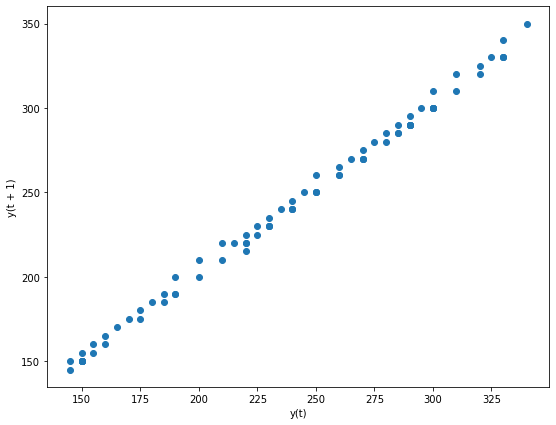

In [6]:
plt.figure(figsize=(9,7))
lag_plot(rental_data.loc[1].astype('int'))
plt.show()

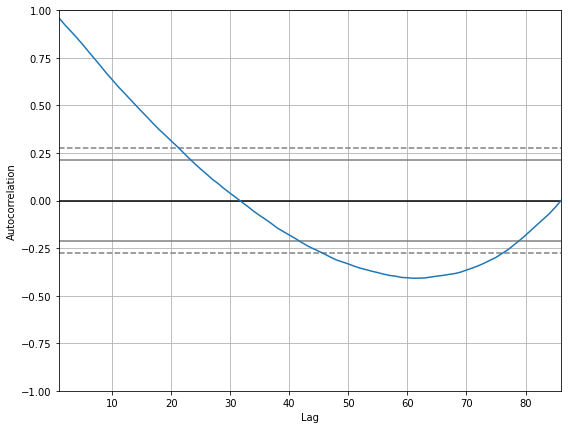

In [28]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(9,7))
autocorrelation_plot(rental_data.loc[1].astype('int'))
plt.show()

<Figure size 648x504 with 0 Axes>

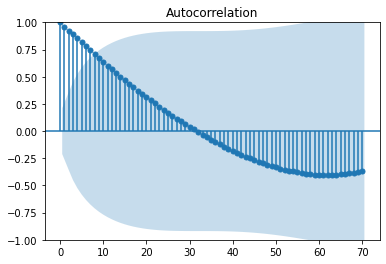

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(9,7))
plot_acf(rental_data.loc[1].astype('int'), lags=70)
plt.show()

In [45]:
a = rental_data.loc[0].astype('int')
a

Rental_total_Mar_2000    175
Rental_total_Jun_2000    180
Rental_total_Sep_2000    180
Rental_total_Dec_2000    180
Rental_total_Mar_2001    180
                        ... 
Rental_total_Jun_2020    495
Rental_total_Sep_2020    490
Rental_total_Dec_2020    485
Rental_total_Mar_2021    480
Rental_total_Jun_2021    480
Name: 0, Length: 86, dtype: int32

In [57]:
df.dtypes

t-1    float64
t+1    float64
dtype: object

Test MSE: 14.286


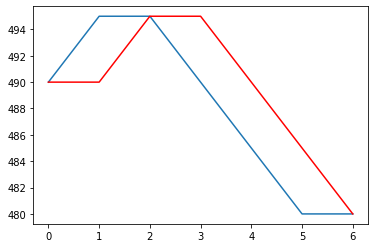

In [56]:
values = pd.DataFrame(rental_data.loc[0].astype('float').values)
df = pd.concat([values.shift(1), values], axis=1)
df = df.fillna(0)
df.columns = ['t-1', 't+1']
X = df.values
################
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]


# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in test_X:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

predicted=489.645558, expected=490.000000
predicted=486.367628, expected=495.000000
predicted=495.280448, expected=495.000000
predicted=497.412022, expected=490.000000
predicted=491.789945, expected=485.000000
predicted=491.276845, expected=480.000000
predicted=493.840650, expected=480.000000
Test RMSE: 8.405


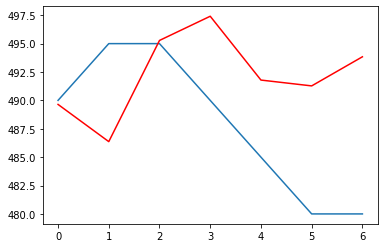

In [39]:
# create and evaluate an updated autoregressive model
from statsmodels.tsa.ar_model import AutoReg
# split dataset
X = rental_data.loc[0].astype('float').values
train, test = X[1:len(X)-7], X[len(X)-7:]

# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()

for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [51]:
rental_pred_name = ['Sep_2021',
					'Dec_2021',
					'Mar_2022',
					'Jun_2022',
					'Sep_2022',
					'Dec_2022',
					'Mar_2023',
					'Jun_2023',
					'Sep_2023',
					'Dec_2023',
					'Mar_2024',
					'Jun_2024',
					'Sep_2024',
					'Dec_2024',
					'Mar_2025',
					'Jun_2025',
					'Sep_2025',
					'Dec_2025',
					'Mar_2026',
					'Jun_2026',
					'Sep_2026',
					'Dec_2026',
					'Mar_2027',
					'Jun_2027',
					'Sep_2027',
					'Dec_2027']
rental_col = rental_data.columns.str.slice(start=13).to_list()
rental_col.extend(rental_pred_name)

In [71]:
# create and evaluate an updated autoregressive model
from statsmodels.tsa.ar_model import AutoReg
# split dataset
PREDICT_LEN = 26
result_df = pd.DataFrame()

index = 0
while index < len(rental_data):
	X = rental_data.iloc[index,:].astype('float').values
	train, test = X[1:len(X)], X[len(X)-PREDICT_LEN:]

	# train autoregression
	window = 29
	model = AutoReg(train, lags=29)
	model_fit = model.fit()
	coef = model_fit.params

	# walk forward over time steps in test
	history = train[len(train)-window:]
	history = [history[i] for i in range(len(history))]
	predictions = list()

	for t in range(len(test)):
		length = len(history)
		lag = [history[i] for i in range(length-window,length)]
		yhat = coef[0]
		for d in range(window):
			yhat += coef[d+1] * lag[window-d-1]
		obs = test[t]
		predictions.append(yhat)
		history.append(obs)
		# print('predicted=%f' % (yhat))

	total_value = rental_data.astype('float').iloc[index,:].to_list()
	total_value.extend(predictions)
	
	temp = pd.DataFrame()
	temp = temp.append(total_value).transpose()
	result_df = result_df.append(temp).reset_index(drop=True)
	index += 1

result_df.columns = rental_col
result_df['suburb'] = rental_median_data['suburb']

result_df
# plot
# plt.figure(figsize=(15,10))
# plt.plot(rental_col, total_value, color='red', marker='o')
# plt.xticks(rotation=90)
# plt.show()

,Mar_2000,Jun_2000,Sep_2000,Dec_2000,Mar_2001,Jun_2001,Sep_2001,Dec_2001,Mar_2002,Jun_2002,...,Dec_2025,Mar_2026,Jun_2026,Sep_2026,Dec_2026,Mar_2027,Jun_2027,Sep_2027,Dec_2027,suburb
0,175.0,180.0,180.0,180.0,180.0,185.0,190.0,195.0,200.0,200.0,...,469.574097,526.065646,474.189620,484.067933,522.381421,494.496920,475.188807,507.034500,496.033588,YARRAVILLE
1,145.0,145.0,150.0,150.0,150.0,150.0,150.0,150.0,150.0,155.0,...,319.046584,320.858474,325.346623,328.736032,320.912573,343.658688,335.790050,325.593847,329.971806,WODONGA
2,220.0,225.0,230.0,240.0,245.0,240.0,245.0,250.0,250.0,260.0,...,434.183664,436.871822,449.875827,455.513573,461.876829,455.353029,453.598312,443.939995,438.262283,WINDSOR
3,240.0,240.0,240.0,240.0,250.0,255.0,260.0,263.0,263.0,260.0,...,524.470635,515.384097,515.539181,527.285425,535.478072,529.469293,517.845583,514.068377,507.597256,WILLIAMSTOWN
4,150.0,150.0,155.0,170.0,163.0,170.0,165.0,170.0,175.0,180.0,...,390.312403,384.918506,368.248812,390.638917,409.917082,395.395415,387.222206,393.031553,393.077658,WHITTLESEA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,165.0,170.0,170.0,170.0,175.0,175.0,175.0,180.0,180.0,180.0,...,392.380998,410.023274,404.120968,414.890740,397.244590,402.524281,400.200097,398.123568,407.350978,ALTONA
209,150.0,146.0,150.0,155.0,160.0,165.0,165.0,170.0,175.0,180.0,...,441.695679,455.260395,446.944266,457.218632,443.172160,424.690491,434.255934,423.291250,403.343488,ALPHINGTON
210,130.0,135.0,135.0,135.0,140.0,140.0,140.0,150.0,150.0,155.0,...,327.984800,336.803715,345.034881,353.766871,328.032076,340.437585,368.237750,371.681329,346.022797,ALFREDTON
211,260.0,260.0,270.0,275.0,275.0,280.0,280.0,290.0,300.0,300.0,...,511.226185,534.002501,582.332393,625.133872,635.897504,596.620376,560.648760,513.754646,488.854303,ALBERT PARK


In [73]:
result_df.to_csv('../data/curated/predict_rental_AutoReg.csv')

In [11]:
month_list = ['Mar', 'Jun', 'Sep', 'Dec']
col_name_rental = []
for i in range(2021, 2028):
    count = 0
    if i == 2021:
        count = 2
        index = 2
        for j in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1
    else:
        count = 4
        index = 0
        for k in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1

col_name_rental

['Rental_total_Sep_2021',
 'Rental_total_Dec_2021',
 'Rental_total_Mar_2022',
 'Rental_total_Jun_2022',
 'Rental_total_Sep_2022',
 'Rental_total_Dec_2022',
 'Rental_total_Mar_2023',
 'Rental_total_Jun_2023',
 'Rental_total_Sep_2023',
 'Rental_total_Dec_2023',
 'Rental_total_Mar_2024',
 'Rental_total_Jun_2024',
 'Rental_total_Sep_2024',
 'Rental_total_Dec_2024',
 'Rental_total_Mar_2025',
 'Rental_total_Jun_2025',
 'Rental_total_Sep_2025',
 'Rental_total_Dec_2025',
 'Rental_total_Mar_2026',
 'Rental_total_Jun_2026',
 'Rental_total_Sep_2026',
 'Rental_total_Dec_2026',
 'Rental_total_Mar_2027',
 'Rental_total_Jun_2027',
 'Rental_total_Sep_2027',
 'Rental_total_Dec_2027']

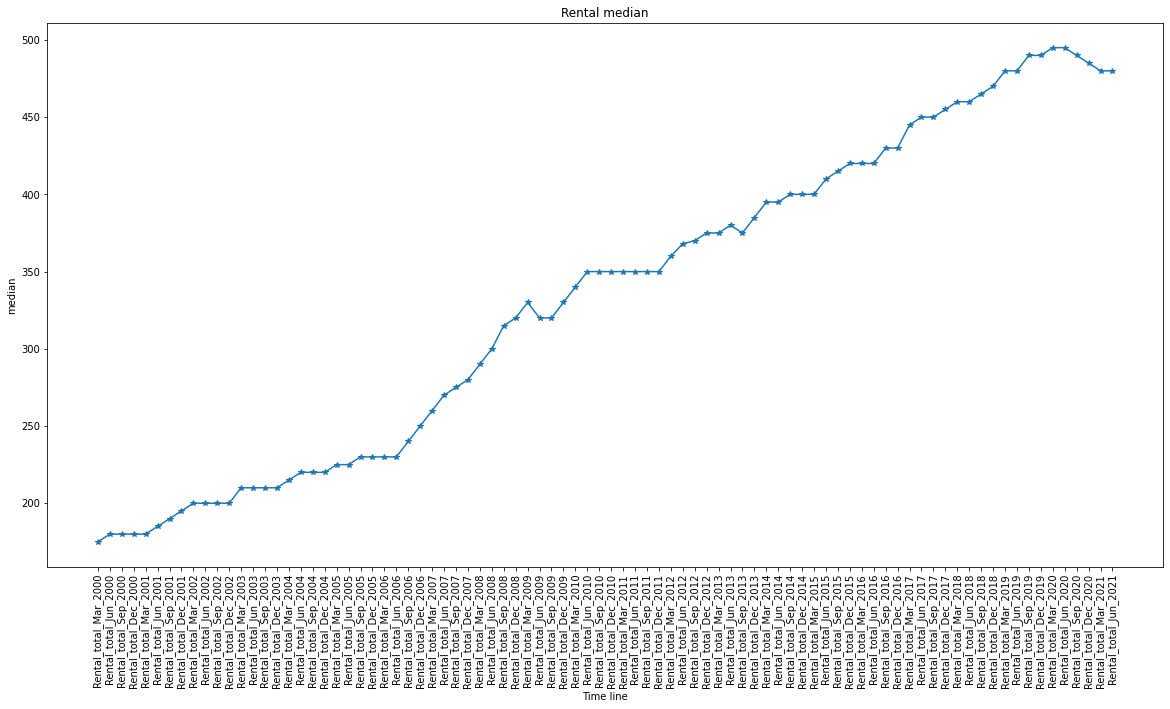

In [6]:
plt.figure(figsize=(20,10))
plt.plot(column_names, rental_data.loc[0].astype('int'), marker='*')
plt.title('Rental median')
plt.ylabel('median')
plt.xlabel('Time line')
plt.xticks(rotation=90)
plt.show()

In [63]:
# train_year = []
# for i in rental_data.columns:
#     train_year.append(int(i[-2:]))
# train_year


train_year = []
for year in range(22):
    for month in range(3,15,3):
        if month == 9 and year == 21:
                break
        months = year * 12 + month
        train_year.append(months)
            # print(year,'-',month)
len(train_year)

86

In [64]:

# predict_year
month_number = 4
predict_year_number = 6
lefted_year = 2


predict_end_year = lefted_year + month_number * predict_year_number
predict_year = []
continure_year = train_year[-1]
for i in range(predict_end_year):
    continure_year = continure_year + 3
    predict_year.append(continure_year)
predict_year

[261,
 264,
 267,
 270,
 273,
 276,
 279,
 282,
 285,
 288,
 291,
 294,
 297,
 300,
 303,
 306,
 309,
 312,
 315,
 318,
 321,
 324,
 327,
 330,
 333,
 336]

In [65]:
len(predict_year)

26

In [34]:
rental_data = rental_data.replace('-', 0)

In [35]:
from sklearn.linear_model import Ridge
train_x = rental_data.loc[:, 'Rental_total_Mar_2000': 'Rental_total_Mar_2021']
train_y = rental_data['Rental_total_Jun_2021']

# split train test dataset
# x_train_rent, x_test_rent, y_train_rent, y_test_rent = train_test_split(train_x,train_y, train_size=0.7,test_size=0.3,random_state=42)

# set up ridge regression
ridge = Ridge(alpha=50)
ridge.fit(train_x, train_y)
pred=ridge.predict(train_x)
print("The score is: ", ridge.score(train_x, train_y))


# calculate rmse for model
mse = mean_squared_error(train_y,pred)
rmse = mse ** (1/2)
print("The predict rmse is: ", rmse)

The score is:  0.9970160077680812
The predict rmse is:  3.883692155039328


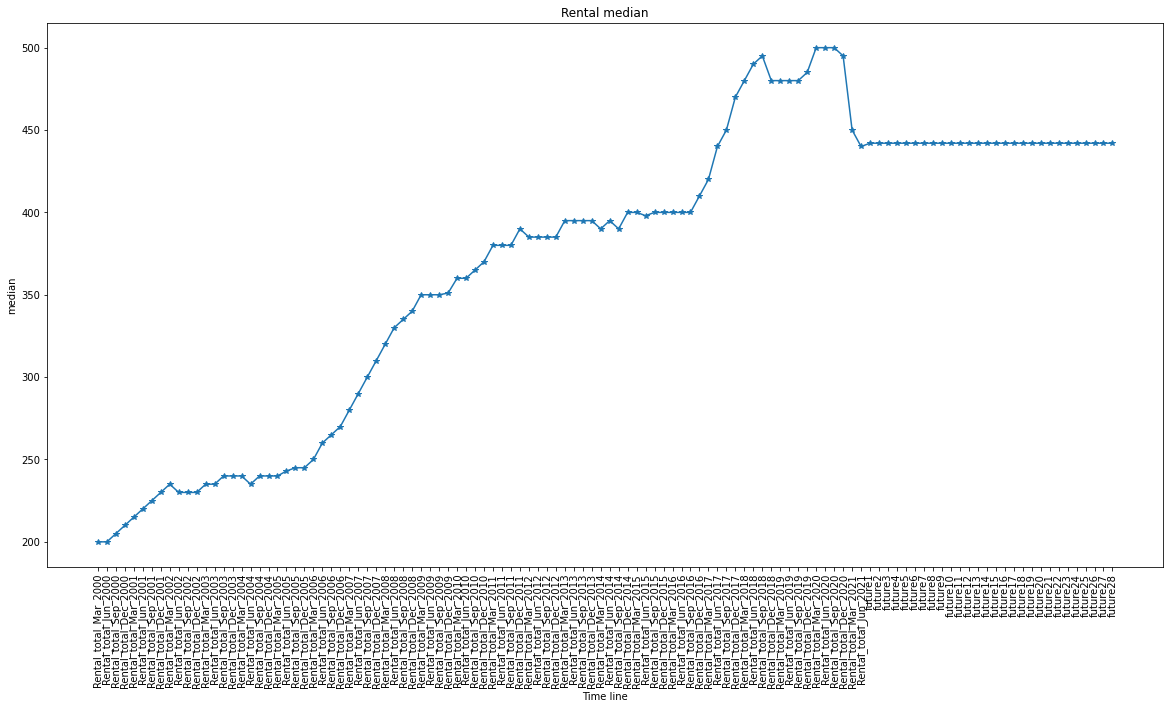

In [36]:
history_data = rental_data.loc[:, 'Rental_total_Mar_2000': 'Rental_total_Jun_2021']
ridge_df = rental_data.copy()
pred_future1 = ridge.predict(train_x)
future1 = pred_future1.tolist()
ridge_df['future1'] = future1

for i in range(predict_end_year+1):
    # print(i+1)
    history_data = ridge_df.loc[:, 'Rental_total_Mar_2000': f'future{i+1}']
    ridge.fit(history_data, history_data[f'future{i+1}'])
    pred_future1 = ridge.predict(history_data)
    future1 = pred_future1.tolist()
    ridge_df[f'future{i+2}'] = future1


# rental_data.columns
plt.figure(figsize=(20,10))
plt.plot(ridge_df.columns, ridge_df.loc[0].astype('int'), marker='*')
plt.title('Rental median')
plt.ylabel('median')
plt.xlabel('Time line')
plt.xticks(rotation=90)
plt.show()


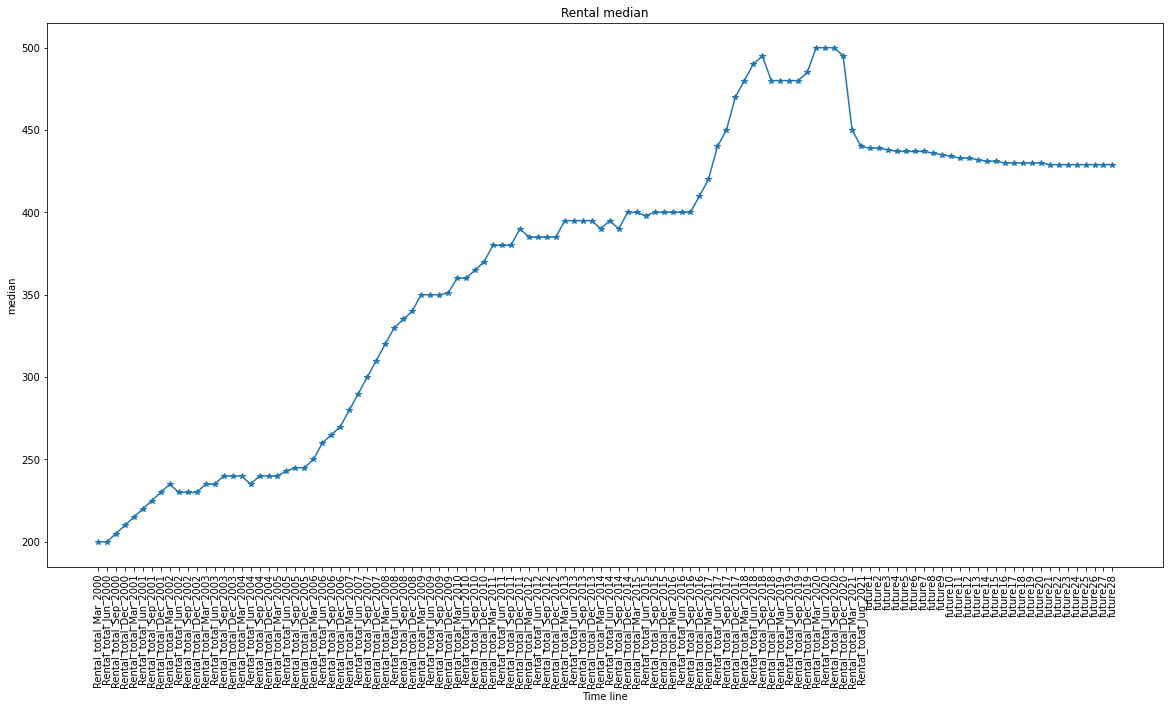

In [48]:
svr_df = rental_data.copy()
regr = SVR(kernel = 'poly', C=100, epsilon=1)
regr.fit(train_x, train_y)

X = svr_df.loc[:, 'Rental_total_Mar_2000': 'Rental_total_Mar_2021']
predict_svr = regr.predict(X)
svr_df['future1'] = predict_svr
# regr.fit(X, X['future1'])
# regr.predict(X)

for i in range(predict_end_year + 1):
    X = svr_df.loc[:, 'Rental_total_Mar_2000': f'future{i+1}']
    regr.fit(X, X[f'future{i+1}'])
    pred_future1 = regr.predict(X)
    future1 = pred_future1.tolist()
    svr_df[f'future{i+2}'] = future1
    
# rental_data.columns
plt.figure(figsize=(20,10))
plt.plot(svr_df.columns, svr_df.loc[0].astype('int'), marker='*')
plt.title('Rental median')
plt.ylabel('median')
plt.xlabel('Time line')
plt.xticks(rotation=90)
plt.show()

In [39]:
# predict_median_price = linear_model_function(x_train, y_train, x_predict)
predict_rental_median = pd.DataFrame()
for index in range(len(rental_data)):
    rental_median_value = rental_data.iloc[index, :].astype('float').to_list()
    # print(rental_median_value)
    rental_median_train_year = train_year
    rental_median_predict_year = predict_year
    rental_median_final_df = linear_model_function(rental_median_train_year, rental_median_value, rental_median_predict_year)
    final_df = [predict_rental_median, rental_median_final_df.transpose()]
    predict_rental_median = pd.concat(final_df)

Intercept    189.236662
X              1.212479
dtype: float64
Intercept    234.668947
X              1.488860
dtype: float64
Intercept    235.869767
X              1.485004
dtype: float64
Intercept    260.743639
X              1.081711
dtype: float64
Intercept    170.765800
X              1.075393
dtype: float64
Intercept    198.756224
X              1.072972
dtype: float64
Intercept    238.090834
X              1.431630
dtype: float64
Intercept    309.270041
X              1.262031
dtype: float64
Intercept    293.799453
X              1.050811
dtype: float64
Intercept    221.824897
X              1.065050
dtype: float64
Intercept    344.359234
X              0.872236
dtype: float64
Intercept    202.557866
X              0.969618
dtype: float64
Intercept    216.837756
X              1.267393
dtype: float64
Intercept    226.075513
X              1.357347
dtype: float64
Intercept    189.469494
X              1.087822
dtype: float64
Intercept    175.056635
X              1.104618
dtype: 

In [40]:
predict_rental_median = predict_rental_median.astype('int')
predict_rental_median

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
Y,200,200,205,210,215,220,225,230,235,230,...,563,567,571,574,578,582,585,589,592,596
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
Y,260,260,265,270,270,275,280,280,290,290,...,694,699,703,708,712,717,721,725,730,734
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336
Y,150,155,155,160,160,160,160,160,165,165,...,425,428,431,433,436,439,442,445,448,451
X,3,6,9,12,15,18,21,24,27,30,...,309,312,315,318,321,324,327,330,333,336


In [41]:
predict_rental_median = predict_rental_median.loc['Y', :].copy()
predict_rental_median.shape

(141, 112)

In [42]:
month_list = ['Mar', 'Jun', 'Sep', 'Dec']
col_name_rental = []
for i in range(2021, 2028):
    count = 0
    if i == 2021:
        count = 2
        index = 2
        for j in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1
    else:
        count = 4
        index = 0
        for k in range(count):
            col_name_rental.append(f'Rental_total_{month_list[index]}_{i}')
            index = index + 1

col_name_rental

['Rental_total_Sep_2021',
 'Rental_total_Dec_2021',
 'Rental_total_Mar_2022',
 'Rental_total_Jun_2022',
 'Rental_total_Sep_2022',
 'Rental_total_Dec_2022',
 'Rental_total_Mar_2023',
 'Rental_total_Jun_2023',
 'Rental_total_Sep_2023',
 'Rental_total_Dec_2023',
 'Rental_total_Mar_2024',
 'Rental_total_Jun_2024',
 'Rental_total_Sep_2024',
 'Rental_total_Dec_2024',
 'Rental_total_Mar_2025',
 'Rental_total_Jun_2025',
 'Rental_total_Sep_2025',
 'Rental_total_Dec_2025',
 'Rental_total_Mar_2026',
 'Rental_total_Jun_2026',
 'Rental_total_Sep_2026',
 'Rental_total_Dec_2026',
 'Rental_total_Mar_2027',
 'Rental_total_Jun_2027',
 'Rental_total_Sep_2027',
 'Rental_total_Dec_2027']

In [43]:
train_col_name = column_names
for i in range(len(col_name_rental)):
    train_col_name.append(col_name_rental[i])

full_name = train_col_name
len(full_name)

112

In [44]:
predict_rental_median.columns = full_name
predict_rental_median

,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,Rental_total_Jun_2002,...,Rental_total_Sep_2025,Rental_total_Dec_2025,Rental_total_Mar_2026,Rental_total_Jun_2026,Rental_total_Sep_2026,Rental_total_Dec_2026,Rental_total_Mar_2027,Rental_total_Jun_2027,Rental_total_Sep_2027,Rental_total_Dec_2027
Y,200,200,205,210,215,220,225,230,235,230,...,563,567,571,574,578,582,585,589,592,596
Y,260,260,265,270,270,275,280,280,290,290,...,694,699,703,708,712,717,721,725,730,734
Y,0,340,0,0,0,0,0,0,320,340,...,694,699,703,708,712,717,721,725,730,734
Y,265,268,280,273,290,295,300,320,320,320,...,594,598,601,604,607,611,614,617,620,624
Y,180,180,180,185,185,190,195,195,200,200,...,503,506,509,512,515,519,522,525,528,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y,185,185,190,200,200,200,210,210,215,220,...,498,501,504,507,510,514,517,520,523,526
Y,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
Y,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
Y,150,155,155,160,160,160,160,160,165,165,...,425,428,431,433,436,439,442,445,448,451


In [45]:
predict_rental_median['surburb'] = rental_median_data['suburb'].tolist()
predict_rental_median = predict_rental_median.set_index('surburb')
predict_rental_median

,Rental_total_Mar_2000,Rental_total_Jun_2000,Rental_total_Sep_2000,Rental_total_Dec_2000,Rental_total_Mar_2001,Rental_total_Jun_2001,Rental_total_Sep_2001,Rental_total_Dec_2001,Rental_total_Mar_2002,Rental_total_Jun_2002,...,Rental_total_Sep_2025,Rental_total_Dec_2025,Rental_total_Mar_2026,Rental_total_Jun_2026,Rental_total_Sep_2026,Rental_total_Dec_2026,Rental_total_Mar_2027,Rental_total_Jun_2027,Rental_total_Sep_2027,Rental_total_Dec_2027
surburb,,,,,,,,,,,,,,,,,,,,,
ARMADALE,200,200,205,210,215,220,225,230,235,230,...,563,567,571,574,578,582,585,589,592,596
CARLTON NORTH,260,260,265,270,270,275,280,280,290,290,...,694,699,703,708,712,717,721,725,730,734
DOCKLANDS,0,340,0,0,0,0,0,0,320,340,...,694,699,703,708,712,717,721,725,730,734
EAST MELBOURNE,265,268,280,273,290,295,300,320,320,320,...,594,598,601,604,607,611,614,617,620,624
ST KILDA EAST,180,180,180,185,185,190,195,195,200,200,...,503,506,509,512,515,519,522,525,528,532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AVONDALE HEIGHTS,185,185,190,200,200,200,210,210,215,220,...,498,501,504,507,510,514,517,520,523,526
NEWPORT,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638
SPOTSWOOD,170,175,180,180,180,185,190,190,200,200,...,599,603,608,612,616,621,625,629,634,638


In [46]:
predict_rental_median.to_csv('../data/curated/predict_rental_median.csv')

## k best

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", LinearRegression())])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", SVC(max_iter = 20000))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", Lasso(alpha=1.0))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
# find the best k value and score function for feature selection via LogisticRegression
pipeline = Pipeline([('kbest', SelectKBest()), ("clf", Ridge(alpha=1.0))])
param = {"kbest__score_func": (f_regression, chi2, mutual_info_regression),
         "kbest__k": (30,50,80,100,130)}
gs = GridSearch(pipeline, param, x_train,y_train)
gs.best_params_

In [ ]:
#Select features by chi-square with data after word vectorization

# fit data for Bow
kbest = SelectKBest(score_func = , k = ).fit(x_train, y_train)

# transform data
kbest_train_x = kbest.transform(x_train)
kbest_test_x = kbest.transform(x_test)


In [ ]:
LR = {}
print("The accuracy of LogisticRegression")
train_acc, test_acc = LR_acc(x_train, x_test, y_train, y_test)
LR["train_acc"] = train_acc
LR["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

SVM = {}
print("The accuracy of SVM")
train_acc, test_acc = SVM_acc(x_train, x_test, y_train, y_test)
SVM["train_acc"] = train_acc
SVM["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

LinearR = {}
print("The accuracy of LinearRegression")
train_acc, test_acc = LinearR_acc(x_train, x_test, y_train, y_test)
LinearR["train_acc"] = train_acc
LinearR["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

ridge = {}
print("The accuracy of Ridge")
train_acc, test_acc = Ridge_acc(x_train, x_test, y_train, y_test)
ridge["train_acc"] = train_acc
ridge["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

lasso = {}
print("The accuracy of Lasso")
train_acc, test_acc = Lasso_acc(x_train, x_test, y_train, y_test)
lasso["train_acc"] = train_acc
lasso["test_acc"] = test_acc
print("Train Accuracy: ", train_acc)
print("Test Accuracy: ", test_acc)
print("********************************")

In [ ]:
acc_dict = [LR, SVM, LinearR, ridge,lasso]
index = ["LogisticRegression", "SVM", "LinearRegression", "Ridge", "Lasso"]
data = [[0,0],[0,0],[0,0],[0,0],[0,0]]
acc_df = pd.DataFrame(data, columns=['train_acc','test_acc'], index =index)

for i in range(5):
    model_name = index[i]
    acc_df.loc[model_name] = list(acc_dict[i].values())

In [ ]:
display(acc_df.sort_values(by=['test_acc'],ascending=False))

model start

In [3]:
rental_price = pd.read_csv('../data/curated/predict_rental_median.csv')
property_df = pd.read_csv('../data/curated/cleaned_property_data_new.csv')

In [4]:
rental_price_now = rental_price.loc[:, 'Rental_total_Sep_2022':'Rental_total_Sep_2027'].copy()
rental_price_now['suburb'] = rental_price['surburb'].to_list()

In [5]:
property_df_new = pd.merge(property_df, rental_price_now, on='suburb', how='left').fillna(0)

In [6]:
property_df_new

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,Rental_total_Jun_2025,Rental_total_Sep_2025,Rental_total_Dec_2025,Rental_total_Mar_2026,Rental_total_Jun_2026,Rental_total_Sep_2026,Rental_total_Dec_2026,Rental_total_Mar_2027,Rental_total_Jun_2027,Rental_total_Sep_2027
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,MELBOURNE,3000,Studio,1,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
3,918/422 Collins St Melbourne VIC 3000,600,9,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,2,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
4,602/118 Franklin Street Melbourne VIC 3000,330,6,MELBOURNE,3000,Apartment / Unit / Flat / Penhouse,0,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,16B Sandy Mount Avenue Inverloch VIC 3996,550,1,INVERLOCH,3996,House,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14501,28 Beachcomber Drive Inverloch VIC 3996,550,1,INVERLOCH,3996,House,1,0,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14502,14 Inverloch Parade Inverloch VIC 3996,440,1,INVERLOCH,3996,House,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14503,Inverloch VIC 3996,580,1,INVERLOCH,3996,House,0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
property_df_new['type'].unique()

array(['Apartment / Unit / Flat / Penhouse', 'Studio', 'Townhouse',
       'House'], dtype=object)

In [8]:
property_df_new = property_df_new.replace(to_replace=r'Apartment \/ Unit \/ Flat \/ Penhouse', value=1, regex=True)
property_df_new = property_df_new.replace(to_replace=r'Studio', value=2, regex=True)
property_df_new = property_df_new.replace(to_replace=r'Townhouse', value=3, regex=True)
property_df_new = property_df_new.replace(to_replace=r'House', value=4, regex=True)
property_df_new['type'] = property_df_new['type'].astype('int')

In [9]:
def convert_suburb(df):
    suburb_lis = list(df['suburb'].unique())
    for i in range(1,len(suburb_lis)+1):
        df['suburb'] = df['suburb'].replace(suburb_lis[i-1],i)
    return df

In [12]:
# suburb_num_dict = {}
# num = 1
# for i in rental_price_now['suburb']:
#     suburb_num_dict[i] = num
#     num += 1

In [11]:
# property_df_new['suburb_num'] = property_df_new['suburb']
# property_df_new['suburb_num'] = property_df_new['suburb_num'].map(suburb_num_dict).fillna(0)
property_df_new = convert_suburb(property_df_new)

In [12]:
property_df_new

,address,rent_weekly,floor,suburb,postcode,type,furnitured,pool,gym,num_bed,...,Rental_total_Jun_2025,Rental_total_Sep_2025,Rental_total_Dec_2025,Rental_total_Mar_2026,Rental_total_Jun_2026,Rental_total_Sep_2026,Rental_total_Dec_2026,Rental_total_Mar_2027,Rental_total_Jun_2027,Rental_total_Sep_2027
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,14,1,3000,1,0,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,11,1,3000,2,1,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
2,911/408 Lonsdale Street Melbourne VIC 3000,330,9,1,3000,1,0,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
3,918/422 Collins St Melbourne VIC 3000,600,9,1,3000,1,0,0,0,2,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
4,602/118 Franklin Street Melbourne VIC 3000,330,6,1,3000,1,0,0,0,1,...,540.0,543.0,545.0,547.0,550.0,552.0,555.0,557.0,560.0,562.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,16B Sandy Mount Avenue Inverloch VIC 3996,550,1,583,3996,4,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14501,28 Beachcomber Drive Inverloch VIC 3996,550,1,583,3996,4,1,0,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14502,14 Inverloch Parade Inverloch VIC 3996,440,1,583,3996,4,0,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14503,Inverloch VIC 3996,580,1,583,3996,4,0,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
property_df_new.to_csv('../data/curated/prepare_train.csv', index=False)

In [16]:
train_y = pd.DataFrame()
train_df = property_df_new.copy()
train_y['rent_weekly'] = property_df_new['rent_weekly']
predict_feature = property_df_new.iloc[:, 111:131].copy()

# train_df.drop(train_df.columns[[0, 1, 4, 12, 60, 107]], axis=1, inplace=True)
# train_df.drop(train_df.iloc[:, 104:124], axis=1, inplace=True)

In [19]:
train_df.drop(train_df.columns[[0, 1, 4, 12, 60, 107]], axis=1, inplace=True)

In [23]:
train_df.drop(train_df.iloc[:, 105:], axis=1, inplace=True)

In [24]:
train_df.head(3)

,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,SECONDARY SCHOOL,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,Rental_total_Sep_2022
0,14,1,1,0,0,0,1,1,0,11.0,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0,513.0
1,11,1,2,1,0,0,1,1,0,11.0,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1,513.0
2,9,1,1,0,0,0,1,1,0,11.0,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3,513.0


In [29]:
predict_df = train_df.copy()
# predict_df[predict_df.columns[104]] = predict_feature[predict_feature.columns[0]]
predict_df.head(5)

,floor,suburb,type,furnitured,pool,gym,num_bed,num_bath,num_car_park,SECONDARY SCHOOL,...,cloest_HELIPORT,cloest_AIRPORT,cloest_IRON ORE PROCESSOR,cloest_MILL/TIMBER OPERATIONS,cloest_BEACH,cloest_TRAM STATION,cloest_BUS,cloest_TRAIN_STATION_duration,cloest_TRAIN_STATION_distance,Rental_total_Sep_2022
0,14,1,1,0,0,0,1,1,0,11.0,...,4602.243139,10572.425042,58968.064246,63924.811459,4924.342233,122.485883,37.427155,41.4,282.0,515.0
1,11,1,2,1,0,0,1,1,0,11.0,...,5564.850055,11141.121440,59761.515319,63682.479322,5709.431207,195.490530,46.128039,117.8,762.1,515.0
2,9,1,1,0,0,0,1,1,0,11.0,...,4821.362032,10953.719391,59069.898510,64077.037494,5011.485174,205.391048,21.831936,69.9,515.3,515.0
3,9,1,1,0,0,0,2,1,0,11.0,...,4669.104831,11385.787890,58748.794039,64563.056533,4705.273027,36.919276,112.474189,138.9,1103.0,515.0
4,6,1,1,0,0,0,1,1,0,11.0,...,4873.599965,10462.311621,59264.949130,63646.805335,5225.088718,168.187210,167.368064,62.6,533.6,515.0


In [45]:
quarter = 12
year = 22
predict_result_df_r = pd.DataFrame()
predict_df = train_df.copy()
train_x = train_df.copy()

for i in range(12):
    predict_df[predict_df.columns[104]] = predict_feature[predict_feature.columns[i]]
    ridge = Ridge(alpha=50)
    ridge.fit(train_x, train_y['rent_weekly'])
    pred = ridge.predict(predict_df)
    predict_result_df_r[f'predict_{quarter}_{year}'] = pred
    train_y['rent_weekly'] = pred
    train_x[train_x.columns[104]] = predict_feature[predict_feature.columns[i]]

    print(i)

    if quarter == 12:
        quarter = 3
        year += 1
    else:
        quarter += 3

predict_result_df_r.to_csv('../data/curated/ridge_result.csv')

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
quarter = 12
year = 22
predict_result_df_svr = pd.DataFrame()
predict_df = train_df.copy()
train_x = train_df.copy()

for i in range(12):
    predict_df[predict_df.columns[104]] = predict_feature[predict_feature.columns[i]]
    regr = SVR(kernel = 'poly', C=100, epsilon=1)
    regr.fit(train_x, train_y['rent_weekly'])
    predict_svr = regr.predict(predict_df)
    predict_result_df_svr[f'predict_{quarter}_{year}'] = predict_svr
    train_y['rent_weekly'] = predict_svr
    train_x[train_x.columns[104]] = predict_feature[predict_feature.columns[i]]
    print(i)

    if quarter == 12:
        quarter = 3
        year += 1
    else:
        quarter += 3

predict_result_df_svr.to_csv('../data/curated/svr_result.csv')

In [ ]:
quarter = 12
year = 22
predict_result_df_lasso = pd.DataFrame()
predict_df = train_df.copy()
train_x = train_df.copy()

for i in range(12):
    predict_df[predict_df.columns[104]] = predict_feature[predict_feature.columns[i]]
    lasso = Lasso(max_iter=300000, alpha = 0.01)
    lasso.fit(train_x, train_y['rent_weekly'])
    pred = lasso.predict(predict_df)
    predict_result_df_lasso[f'predict_{quarter}_{year}'] = pred
    train_y['rent_weekly'] = pred
    train_x[train_x.columns[104]] = predict_feature[predict_feature.columns[i]]
    print(i)

    if quarter == 12:
        quarter = 3
        year += 1
    else:
        quarter += 3

predict_result_df_lasso.to_csv('../data/curated/lasso_result.csv')

end, ignore below

In [30]:
ridge = Ridge(alpha=50)
ridge.fit(train_df, train_y['rent_weekly'])
pred = ridge.predict(predict_df)
print("The score is: ", ridge.score(train_df, train_y['rent_weekly']))
train_y['predict_Dec_21'] = pred
train_y


The score is:  0.011031474529063057


,rent_weekly,predict_Dec_21
0,400,576.371723
1,350,565.845504
2,330,571.878887
3,600,573.341070
4,330,564.996351
...,...,...
14500,550,675.783538
14501,550,627.721365
14502,440,679.294204
14503,580,684.651502


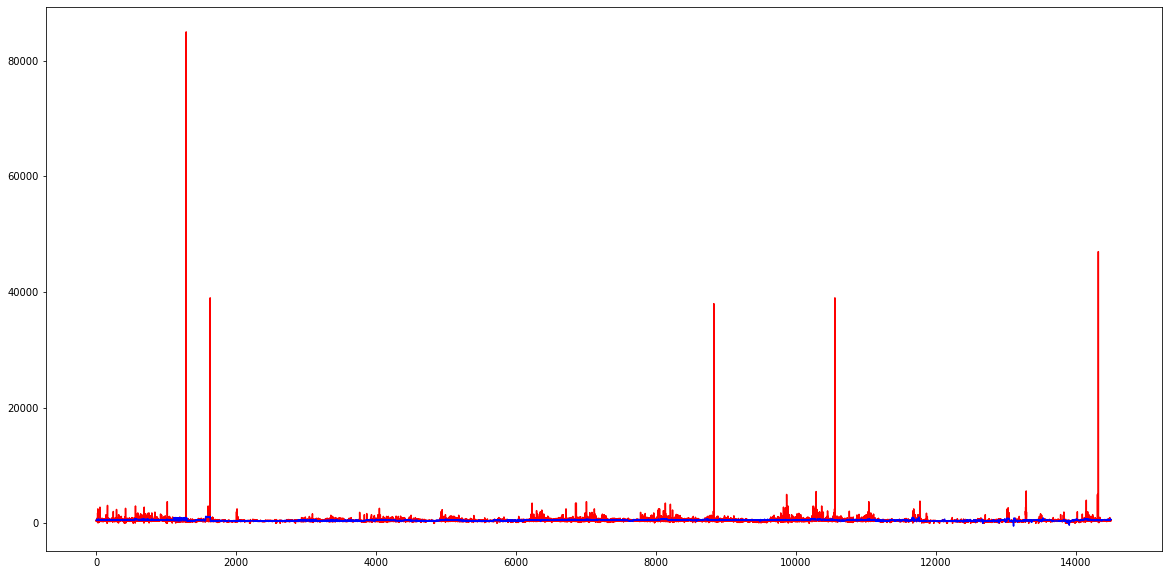

In [71]:
plt.figure(figsize=(20,10))
plt.plot(train_y.index.to_list(), train_y['rent_weekly'], color='r')
plt.plot(train_y.index, train_y['predict_Dec_21'], color='b')
plt.show()

In [72]:
lasso = Lasso(max_iter=300000, alpha = 0.01)
lasso.fit(train_df, train_y['rent_weekly'])
pred = lasso.predict(predict_df)

train_y['predict_Dec_21_2'] = pred
train_y

In [35]:
train_df.iloc[:,[0, 1, 3, 4, 12, 60, 107]]

,address,rent_weekly,suburb,postcode,coordinates,cloest_train_station,cloest_TRAIN_STATION
0,1414/218-228 A'Beckett Street Melbourne VIC 3000,400,MELBOURNE,3000,"[-37.8102832, 144.9566691]","[(208.7885192155693, (-37.811981, 144.955654),...",Flagstaff Railway Station (Melbourne City)
1,11a/131 Lonsdale Sreet Melbourne VIC 3000,350,MELBOURNE,3000,"[-37.810779, 144.9685513]","[(531.6128151500881, (-37.809939, 144.962594),...",Parliament Railway Station (Melbourne City)
2,911/408 Lonsdale Street Melbourne VIC 3000,330,MELBOURNE,3000,"[-37.8125979, 144.9604012]","[(422.63001113194304, (-37.811981, 144.955654)...",Melbourne Central Railway Station (Melbourne C...
3,918/422 Collins St Melbourne VIC 3000,600,MELBOURNE,3000,"[-37.8170971, 144.9601487]","[(692.4760990676032, (-37.811981, 144.955654),...",Flagstaff Railway Station (Melbourne City)
4,602/118 Franklin Street Melbourne VIC 3000,330,MELBOURNE,3000,"[-37.8082052, 144.9589035]","[(507.70605016321656, (-37.811981, 144.955654)...",Melbourne Central Railway Station (Melbourne C...
...,...,...,...,...,...,...,...
14500,16B Sandy Mount Avenue Inverloch VIC 3996,550,INVERLOCH,3996,"[-38.6340011, 145.725239]",[],-1
14501,28 Beachcomber Drive Inverloch VIC 3996,550,INVERLOCH,3996,"[-38.6412502, 145.7031282]",[],-1
14502,14 Inverloch Parade Inverloch VIC 3996,440,INVERLOCH,3996,"[-38.6287143, 145.7358082]",[],-1
14503,Inverloch VIC 3996,580,INVERLOCH,3996,"[-38.6314613, 145.7293638]",[],-1


In [ ]:
regr = SVR(kernel = 'poly', C=100, epsilon=1)
regr.fit(train_df, train_y['rent_weekly'])
predict_svr = regr.predict(predict_df)

In [ ]:
lasso = Lasso(max_iter=300000, alpha = 0.01)
lasso.fit(train_df, train_y['rent_weekly'])
pred = lasso.predict(predict_df)

train_y['predict_Dec_21_2'] = pred
train_y

In [ ]:
# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
dataframe = read_csv(url, header=None)
data = dataframe.values
X, y = data[:, :-1], data[:, -1]
# define model
model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))